In [2]:
import iris
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import iris.quickplot as qplt
import iris.plot as iplt
import datetime
import shutil
from pathlib import Path
import trackpy
from iris.time import PartialDateTime
import cartopy.crs as ccrs
import xarray as xr
import netCDF4 as nc
import scipy
from scipy import ndimage
from scipy.ndimage import label, generate_binary_structure
import seaborn as sns

#import packages that output memory usage:
#from sys import getsizeof

import tobac #tobac package cloned from https://github.com/tobac-project/tobac.git

import warnings
warnings.filterwarnings('ignore')

In [3]:
all_years_cpm = pd.read_hdf('/project/cssp_brazil/mcs_tracking_HG/CPM_HINDCAST_TRACKS/final_tracks_CPM_REGRIDDED/merged/all_years_combined_CCPF/all_years_CCPF_cpm_hindcast.hdf', 'table')
all_years_obs = pd.read_hdf('/project/cssp_brazil/mcs_tracking_HG/OBS_TRACKS/final_tracks_obs/merged/all_years_combined_CCPF/all_years_CCPF_obs.hdf', 'table')

In [4]:
eamz_tracks_cpm = pd.read_hdf('/project/cssp_brazil/mcs_tracking_HG/CPM_HINDCAST_TRACKS/final_tracks_CPM_REGRIDDED/regional_box_tracks/eamz_tracks_cpm.hdf', 'table')
wamz_tracks_cpm = pd.read_hdf('/project/cssp_brazil/mcs_tracking_HG/CPM_HINDCAST_TRACKS/final_tracks_CPM_REGRIDDED/regional_box_tracks/wamz_tracks_cpm.hdf', 'table')
neb_tracks_cpm =pd.read_hdf('/project/cssp_brazil/mcs_tracking_HG/CPM_HINDCAST_TRACKS/final_tracks_CPM_REGRIDDED/regional_box_tracks/neb_tracks_cpm.hdf', 'table')
seb_tracks_cpm =pd.read_hdf('/project/cssp_brazil/mcs_tracking_HG/CPM_HINDCAST_TRACKS/final_tracks_CPM_REGRIDDED/regional_box_tracks/seb_tracks_cpm.hdf', 'table')
lpb_tracks_cpm =pd.read_hdf('/project/cssp_brazil/mcs_tracking_HG/CPM_HINDCAST_TRACKS/final_tracks_CPM_REGRIDDED/regional_box_tracks/lpb_tracks_cpm.hdf', 'table')

In [5]:
eamz_tracks_obs = pd.read_hdf('/project/cssp_brazil/mcs_tracking_HG/OBS_TRACKS/final_tracks_obs/regional_box_tracks/eamz_tracks_obs.hdf', 'table')
wamz_tracks_obs = pd.read_hdf('/project/cssp_brazil/mcs_tracking_HG/OBS_TRACKS/final_tracks_obs/regional_box_tracks/wamz_tracks_obs.hdf', 'table')
neb_tracks_obs = pd.read_hdf('/project/cssp_brazil/mcs_tracking_HG/OBS_TRACKS/final_tracks_obs/regional_box_tracks/neb_tracks_obs.hdf', 'table')
seb_tracks_obs = pd.read_hdf('/project/cssp_brazil/mcs_tracking_HG/OBS_TRACKS/final_tracks_obs/regional_box_tracks/seb_tracks_obs.hdf', 'table')
lpb_tracks_obs = pd.read_hdf('/project/cssp_brazil/mcs_tracking_HG/OBS_TRACKS/final_tracks_obs/regional_box_tracks/lpb_tracks_obs.hdf', 'table')

In [6]:
# function to get total precip over a whole MCS lifetime

def get_total_precip(tracks):
    total_precip = []

    for cell in np.unique(tracks.cell.values):
        subset = tracks[tracks.cell == cell]
        tot_precip = np.sum(subset.total_precip)
        total_precip.append(tot_precip)
    
    return total_precip

In [4]:
### use get_total_precip to find total precip over MCS lifetime ##
total_precip_cpm = get_total_precip(all_years_cpm)
total_precip_obs = get_total_precip(all_years_obs)

In [5]:
cpm_precip_histo, bins = np.histogram(total_precip_cpm, bins= np.linspace(1000,106000,22))
obs_precip_histo, bins = np.histogram(total_precip_obs, bins= np.linspace(1000,106000,22))

cpm_precip_hist = cpm_precip_histo/np.nansum(cpm_precip_histo) * 100
obs_precip_hist = obs_precip_histo/np.nansum(obs_precip_histo) * 100

In [7]:
print(np.mean(total_precip_cpm))
print(np.mean(total_precip_obs))

42186.30658704523
32779.056744173824


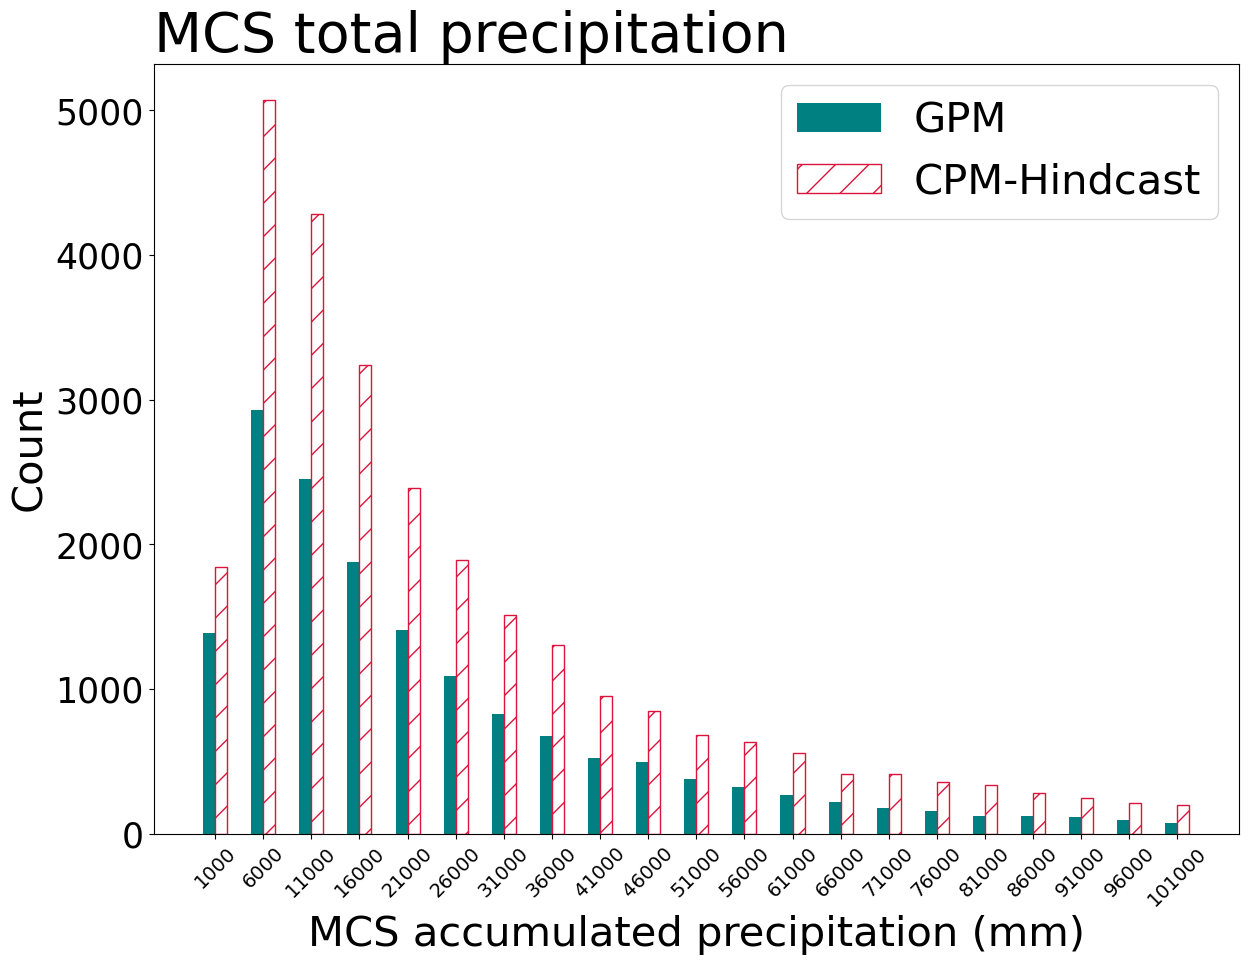

In [8]:
fig = plt.figure(figsize=(14,10))

ax = fig.add_subplot(111)

#sns.set(font_scale=1.5)

t = 40
f= 30
n=25
lf= 35

N = 21
ind = np.arange(N) 
width = 0.25

plt.title('MCS total precipitation', loc='left', fontsize= t )
obs = obs_precip_histo
bar1 = plt.bar(ind, obs, width, color = 'teal',label='GPM')
  
cpm = cpm_precip_histo
bar2 = plt.bar(ind+width, cpm, width, color= 'white', edgecolor='crimson',hatch='/',label='CPM-Hindcast')

plt.xlabel("MCS accumulated precipitation (mm)",fontsize=f)
plt.ylabel('Count',fontsize=f)
plt.xticks(ind+width*0.5, bins.astype(int)[:-1], fontsize=14, rotation=45)
plt.yticks(fontsize=n)
plt.legend(loc='upper right',fontsize=f)
#plt.grid()

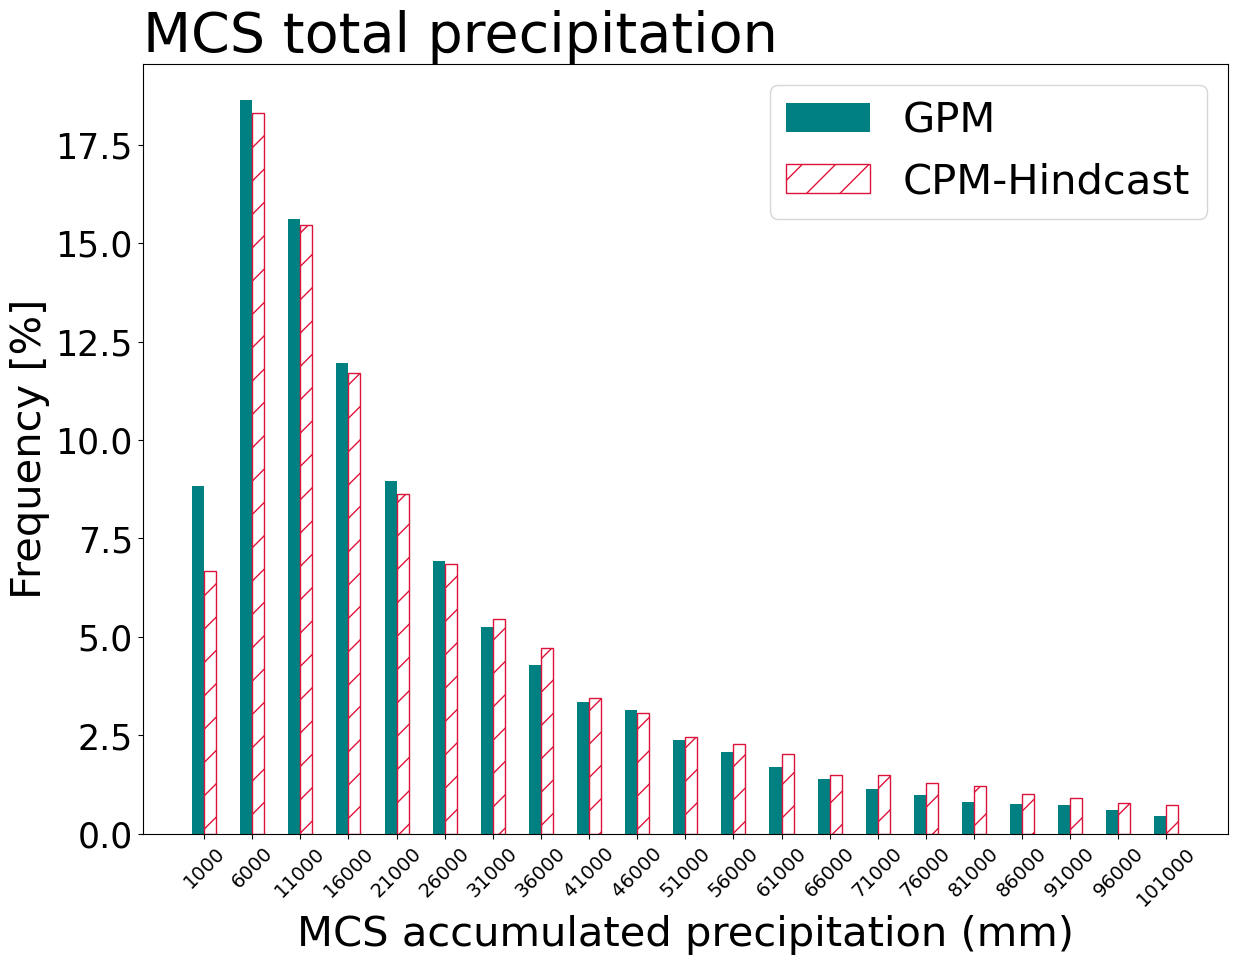

In [9]:
fig = plt.figure(figsize=(14,10))

ax = fig.add_subplot(111)

#sns.set(font_scale=1.5)

t = 40
f= 30
n=25
lf= 35

N = 21
ind = np.arange(N) 
width = 0.25

plt.title('MCS total precipitation', loc='left', fontsize= t )
obs = obs_precip_hist
bar1 = plt.bar(ind, obs, width, color = 'teal',label='GPM')
  
cpm = cpm_precip_hist
bar2 = plt.bar(ind+width, cpm, width, color= 'white', edgecolor='crimson',hatch='/',label='CPM-Hindcast')

plt.xlabel("MCS accumulated precipitation (mm)",fontsize=f)
plt.ylabel('Frequency [%]',fontsize=f)
plt.xticks(ind+width*0.5, bins.astype(int)[:-1], fontsize=14, rotation=45)
plt.yticks(fontsize=n)
plt.legend(loc='upper right',fontsize=f)
#plt.grid()

In [7]:
# function to get total precip over a whole MCS lifetime

def get_total_precip_by_lifetime(tracks):
    total_precip_by_lifetime = []

    for cell in np.unique(tracks.cell.values):
        subset = tracks[tracks.cell == cell]
        tot_precip = np.sum(subset.total_precip)
        lifetime = subset.shape[0]
        tot_precip_by_lifetime = tot_precip / lifetime
        total_precip_by_lifetime.append(tot_precip_by_lifetime)
    
    return total_precip_by_lifetime

In [11]:
total_precip_by_lifetime_cpm = get_total_precip_by_lifetime(all_years_cpm)
total_precip_by_lifetime_obs = get_total_precip_by_lifetime(all_years_obs)

In [12]:
total_precip_by_lifetime_cpm

[3433.5370678901672,
 2075.7457411024307,
 1901.9784633091517,
 1977.7182834148407,
 1760.5000422551082,
 1055.6772058660333,
 924.7400171973488,
 5615.7774668766315,
 624.9255758083558,
 545.8136669847934,
 1759.5730154854912,
 3642.058496621939,
 1806.5395469665527,
 1981.5950927734375,
 2650.7026018415177,
 1976.2293427228929,
 4141.922882739157,
 741.0848785400391,
 842.8905944824219,
 1123.79181060791,
 1283.0867396763392,
 2069.7371708969818,
 2166.3582857572114,
 1752.474860558143,
 1420.2041032964532,
 8572.992953152843,
 1595.7084077935845,
 7634.625762939453,
 878.459103902181,
 310.066588810512,
 482.473764802551,
 8937.924393370966,
 2082.9952087402344,
 1051.8127257029216,
 1648.7303880964007,
 8293.187174479166,
 976.5682110256619,
 1539.0856304168701,
 2765.4456939697266,
 5841.424102783203,
 1213.937520345052,
 621.674319797092,
 10985.452954101562,
 1715.9033745659722,
 1403.4333871694712,
 6061.60888671875,
 12062.746803977272,
 4261.283900669643,
 3282.4991861979165,

In [13]:
cpm_precip_lifetime_histo, bins = np.histogram(total_precip_by_lifetime_cpm, bins= np.linspace(100,9100,25))
obs_precip_lifetime_histo, bins = np.histogram(total_precip_by_lifetime_obs, bins= np.linspace(100,9100,25))

In [14]:
obs_precip_lifetime_histo.shape[0]

24

In [15]:
cpm_precip_lifetime_hist = cpm_precip_lifetime_histo/np.nansum(cpm_precip_lifetime_histo) * 100
obs_precip_lifetime_hist = obs_precip_lifetime_histo/np.nansum(obs_precip_lifetime_histo) * 100

In [16]:
print(np.mean(total_precip_by_lifetime_cpm))
print(np.mean(total_precip_by_lifetime_obs))

2728.9198791247236
2707.939122744214


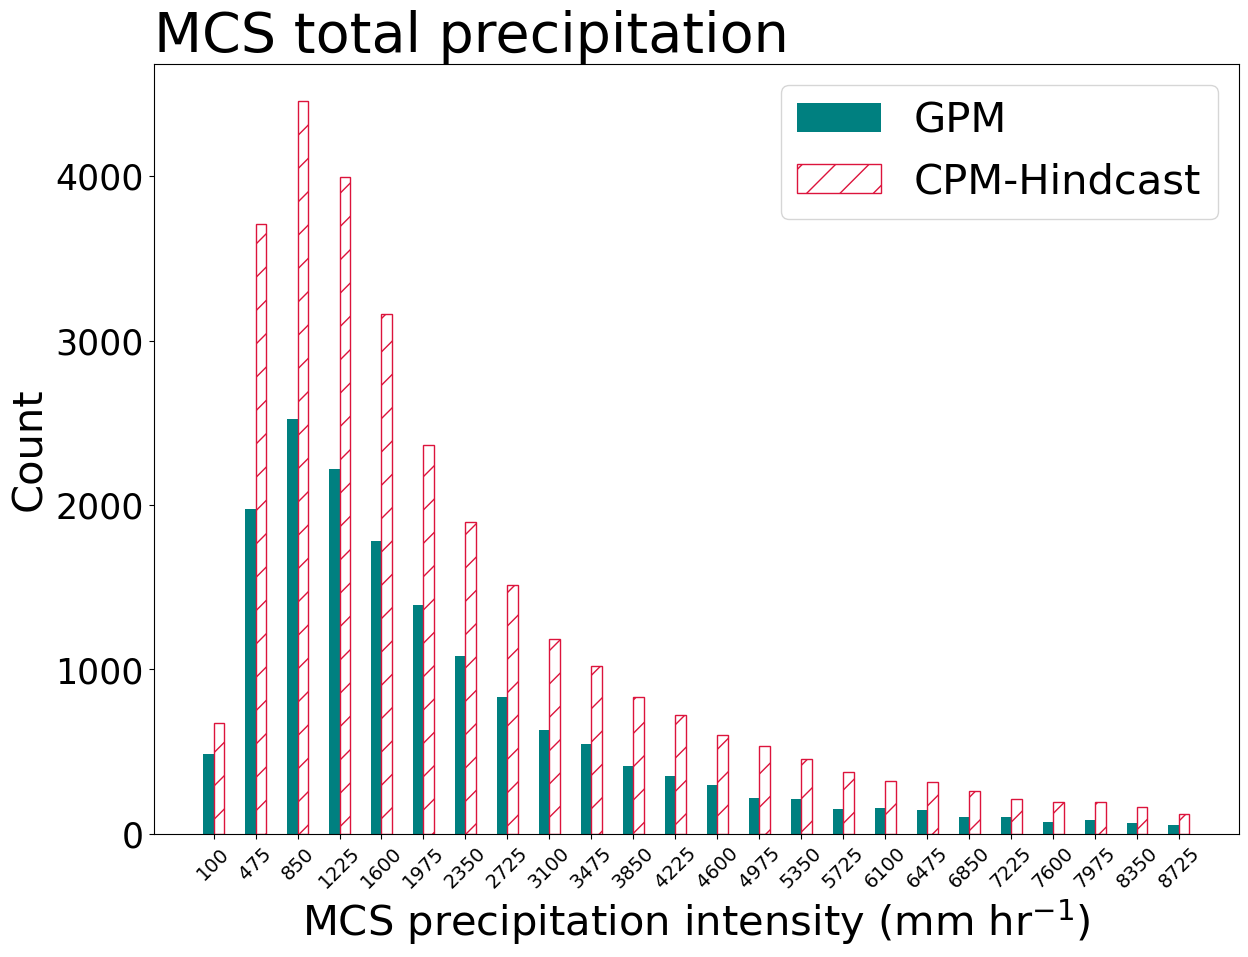

In [26]:
fig = plt.figure(figsize=(14,10))

ax = fig.add_subplot(111)

#sns.set(font_scale=1.5)

t = 40
f= 30
n=25
lf= 35

N = 24
ind = np.arange(N) 
width = 0.25

plt.title('MCS total precipitation', loc='left', fontsize= t )
obs = obs_precip_lifetime_histo
bar1 = plt.bar(ind, obs, width, color = 'teal',label='GPM')
  
cpm = cpm_precip_lifetime_histo
bar2 = plt.bar(ind+width, cpm, width, color= 'white', edgecolor='crimson',hatch='/',label='CPM-Hindcast')

plt.xlabel("MCS precipitation intensity (mm hr$^{-1}$)",fontsize=f)
plt.ylabel('Count',fontsize=f)
plt.xticks(ind+width*0.5, bins.astype(int)[:-1], fontsize=14, rotation=45)
plt.yticks(fontsize=n)
plt.legend(loc='upper right',fontsize=f)
#plt.grid()

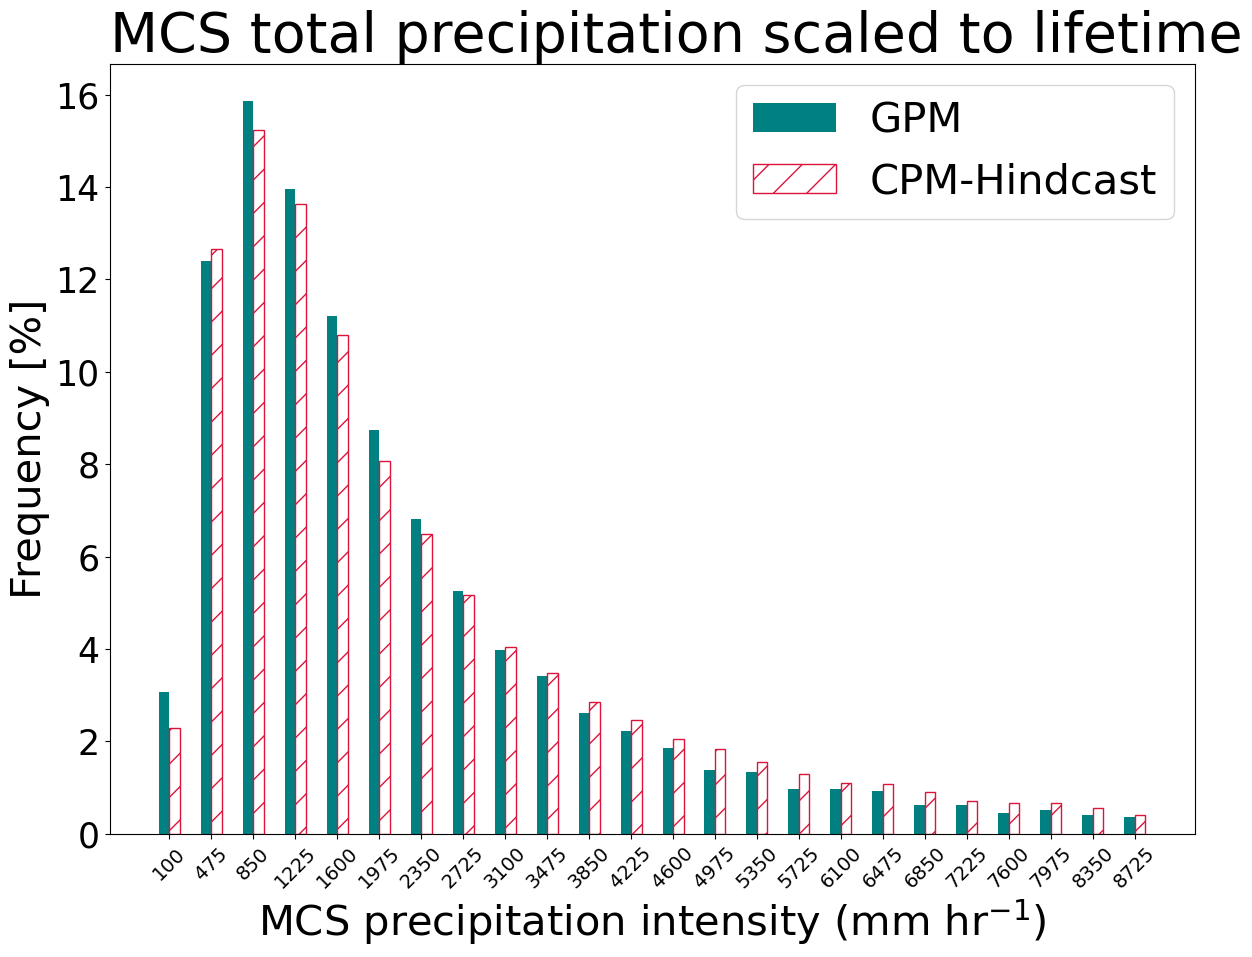

In [27]:
fig = plt.figure(figsize=(14,10))

ax = fig.add_subplot(111)

#sns.set(font_scale=1.5)

t = 40
f= 30
n=25
lf= 35

N = 24
ind = np.arange(N) 
width = 0.25

plt.title('MCS total precipitation scaled to lifetime', loc='left', fontsize= t )
obs = obs_precip_lifetime_hist
bar1 = plt.bar(ind, obs, width, color = 'teal',label='GPM')
  
cpm = cpm_precip_lifetime_hist
bar2 = plt.bar(ind+width, cpm, width, color= 'white', edgecolor='crimson',hatch='/',label='CPM-Hindcast')

plt.xlabel("MCS precipitation intensity (mm hr$^{-1}$)",fontsize=f)
plt.ylabel('Frequency [%]',fontsize=f)
plt.xticks(ind+width*0.5, bins.astype(int)[:-1], fontsize=14, rotation=45)
plt.yticks(fontsize=n)
plt.legend(loc='upper right',fontsize=f)
#plt.grid()

## Plots above but per region ##

In [7]:
### use get_total_precip to find total precip over MCS lifetime ##
eamz_cpm_precip = get_total_precip(eamz_tracks_cpm)
wamz_cpm_precip = get_total_precip(wamz_tracks_cpm)
neb_cpm_precip = get_total_precip(neb_tracks_cpm)
seb_cpm_precip = get_total_precip(seb_tracks_cpm)
lpb_cpm_precip = get_total_precip(lpb_tracks_cpm)




In [8]:
eamz_obs_precip = get_total_precip(eamz_tracks_obs)
wamz_obs_precip = get_total_precip(wamz_tracks_obs)
neb_obs_precip = get_total_precip(neb_tracks_obs)
seb_obs_precip = get_total_precip(seb_tracks_obs)
lpb_obs_precip = get_total_precip(lpb_tracks_obs)

In [33]:
eamz_cpm_precip_histo, bins = np.histogram(eamz_cpm_precip, bins= np.linspace(1000,106000,22))
wamz_cpm_precip_histo, bins = np.histogram(wamz_cpm_precip, bins= np.linspace(1000,106000,22))
neb_cpm_precip_histo, bins = np.histogram(neb_cpm_precip, bins= np.linspace(1000,106000,22))
seb_cpm_precip_histo, bins = np.histogram(seb_cpm_precip, bins= np.linspace(1000,106000,22))
lpb_cpm_precip_histo, bins = np.histogram(lpb_cpm_precip, bins= np.linspace(1000,106000,22))


eamz_obs_precip_histo, bins = np.histogram(eamz_obs_precip, bins= np.linspace(1000,106000,22))
wamz_obs_precip_histo, bins = np.histogram(wamz_obs_precip, bins= np.linspace(1000,106000,22))
neb_obs_precip_histo, bins = np.histogram(neb_obs_precip, bins= np.linspace(1000,106000,22))
seb_obs_precip_histo, bins = np.histogram(seb_obs_precip, bins= np.linspace(1000,106000,22))
lpb_obs_precip_histo, bins = np.histogram(lpb_obs_precip, bins= np.linspace(1000,106000,22))


eamz_cpm_precip_hist = eamz_cpm_precip_histo/np.nansum(eamz_cpm_precip_histo) * 100
wamz_cpm_precip_hist = wamz_cpm_precip_histo/np.nansum(wamz_cpm_precip_histo) * 100
neb_cpm_precip_hist = neb_cpm_precip_histo/np.nansum(neb_cpm_precip_histo) * 100
seb_cpm_precip_hist = seb_cpm_precip_histo/np.nansum(seb_cpm_precip_histo) * 100
lpb_cpm_precip_hist = lpb_cpm_precip_histo/np.nansum(lpb_cpm_precip_histo) * 100



eamz_obs_precip_hist = eamz_obs_precip_histo/np.nansum(eamz_obs_precip_histo) * 100
wamz_obs_precip_hist = wamz_obs_precip_histo/np.nansum(wamz_obs_precip_histo) * 100
neb_obs_precip_hist = neb_obs_precip_histo/np.nansum(neb_obs_precip_histo) * 100
seb_obs_precip_hist = seb_obs_precip_histo/np.nansum(seb_obs_precip_histo) * 100
lpb_obs_precip_hist = lpb_obs_precip_histo/np.nansum(lpb_obs_precip_histo) * 100

In [45]:
eamz_cpm_precip_histo

array([199, 557, 460, 344, 254, 201, 184, 137, 100,  97,  87,  77,  64,
        55,  41,  36,  36,  28,  26,  24,  20])

In [61]:
np.shape(lpb_cpm_precip)

(1007,)

In [9]:
mcs_precip_cpm = pd.DataFrame(np.nan, index = np.arange(4267), columns = ['eamz', 'wamz', 'neb', 'seb', 'lpb'])

In [10]:
mcs_precip_cpm

eamz  wamz  neb  seb  lpb
0      NaN   NaN  NaN  NaN  NaN
1      NaN   NaN  NaN  NaN  NaN
2      NaN   NaN  NaN  NaN  NaN
3      NaN   NaN  NaN  NaN  NaN
4      NaN   NaN  NaN  NaN  NaN
...    ...   ...  ...  ...  ...
4262   NaN   NaN  NaN  NaN  NaN
4263   NaN   NaN  NaN  NaN  NaN
4264   NaN   NaN  NaN  NaN  NaN
4265   NaN   NaN  NaN  NaN  NaN
4266   NaN   NaN  NaN  NaN  NaN

[4267 rows x 5 columns]

In [11]:
mcs_precip_cpm['eamz'].iloc[0:np.shape(eamz_cpm_precip)[0]] = eamz_cpm_precip
mcs_precip_cpm['wamz'] = wamz_cpm_precip
mcs_precip_cpm['neb'].iloc[0:np.shape(neb_cpm_precip)[0]] = neb_cpm_precip
mcs_precip_cpm['seb'].iloc[0:np.shape(seb_cpm_precip)[0]] = seb_cpm_precip
mcs_precip_cpm['lpb'].iloc[0:np.shape(lpb_cpm_precip)[0]] = lpb_cpm_precip

In [12]:
mcs_precip_cpm

eamz           wamz           neb            seb           lpb
0     44879.522217   25710.337684  22886.500549   10172.140189  11612.449265
1     24294.603516    4912.323003  10087.002731   58894.208008  67389.329603
2     24152.000610   12317.011108  41032.708516    9457.939102  13123.437092
3     13758.594442   50354.801270  33789.309814  379218.738281  14351.145969
4     10604.624953  105085.990442  48464.833496   69068.002171  36697.431030
...            ...            ...           ...            ...           ...
4262           NaN   42821.423706           NaN            NaN           NaN
4263           NaN   79753.450684           NaN            NaN           NaN
4264           NaN   79236.181641           NaN            NaN           NaN
4265           NaN   24675.096313           NaN            NaN           NaN
4266           NaN   61963.001160           NaN            NaN           NaN

[4267 rows x 5 columns]

In [13]:
mcs_precip_cpm['type'] = 'CPM-Hindcast'

In [14]:
mcs_precip_cpm

eamz           wamz           neb            seb           lpb  \
0     44879.522217   25710.337684  22886.500549   10172.140189  11612.449265   
1     24294.603516    4912.323003  10087.002731   58894.208008  67389.329603   
2     24152.000610   12317.011108  41032.708516    9457.939102  13123.437092   
3     13758.594442   50354.801270  33789.309814  379218.738281  14351.145969   
4     10604.624953  105085.990442  48464.833496   69068.002171  36697.431030   
...            ...            ...           ...            ...           ...   
4262           NaN   42821.423706           NaN            NaN           NaN   
4263           NaN   79753.450684           NaN            NaN           NaN   
4264           NaN   79236.181641           NaN            NaN           NaN   
4265           NaN   24675.096313           NaN            NaN           NaN   
4266           NaN   61963.001160           NaN            NaN           NaN   

              type  
0     CPM-Hindcast  
1     CPM-Hindcast  
2     CPM-Hindcast  
3     CPM-Hindcast  
4     CPM-Hindcast  
...            ...  
4262  CPM-Hindcast  
4263  CPM-Hindcast  
4264  CPM-Hindcast  
4265  CPM-Hindcast  
4266  CPM-Hindcast  

[4267 rows x 6 columns]

In [15]:
mcs_precip_obs = pd.DataFrame(np.nan, index = np.arange(4267), columns = ['eamz', 'wamz', 'neb', 'seb', 'lpb'])

In [16]:
mcs_precip_obs['eamz'].iloc[0:np.shape(eamz_obs_precip)[0]] = eamz_obs_precip
mcs_precip_obs['wamz'].iloc[0:np.shape(wamz_obs_precip)[0]] = wamz_obs_precip
mcs_precip_obs['neb'].iloc[0:np.shape(neb_obs_precip)[0]] = neb_obs_precip
mcs_precip_obs['seb'].iloc[0:np.shape(seb_obs_precip)[0]] = seb_obs_precip
mcs_precip_obs['lpb'].iloc[0:np.shape(lpb_obs_precip)[0]] = lpb_obs_precip

In [17]:
mcs_precip_obs['type'] = 'Observations'

In [18]:
## combine mcs_precip_obs and mcs_precip_cpm together to make it easier to plot against eachother ##
combined = mcs_precip_cpm.append(mcs_precip_obs)

In [25]:
combined[combined.eamz > 0]

eamz           wamz           neb            seb           lpb  \
0     44879.522217   25710.337684  22886.500549   10172.140189  11612.449265   
1     24294.603516    4912.323003  10087.002731   58894.208008  67389.329603   
2     24152.000610   12317.011108  41032.708516    9457.939102  13123.437092   
3     13758.594442   50354.801270  33789.309814  379218.738281  14351.145969   
4     10604.624953  105085.990442  48464.833496   69068.002171  36697.431030   
...            ...            ...           ...            ...           ...   
2953  26543.934082   71003.310547           NaN            NaN           NaN   
2954   9467.069092   29956.474854           NaN            NaN           NaN   
2955  21862.223930   14121.623474           NaN            NaN           NaN   
2956  29979.712158    4315.235870           NaN            NaN           NaN   
2957  20226.260010  108778.881119           NaN            NaN           NaN   

              type  
0     CPM-Hindcast  
1     CPM-Hindcast  
2     CPM-Hindcast  
3     CPM-Hindcast  
4     CPM-Hindcast  
...            ...  
2953  Observations  
2954  Observations  
2955  Observations  
2956  Observations  
2957  Observations  

[6164 rows x 6 columns]

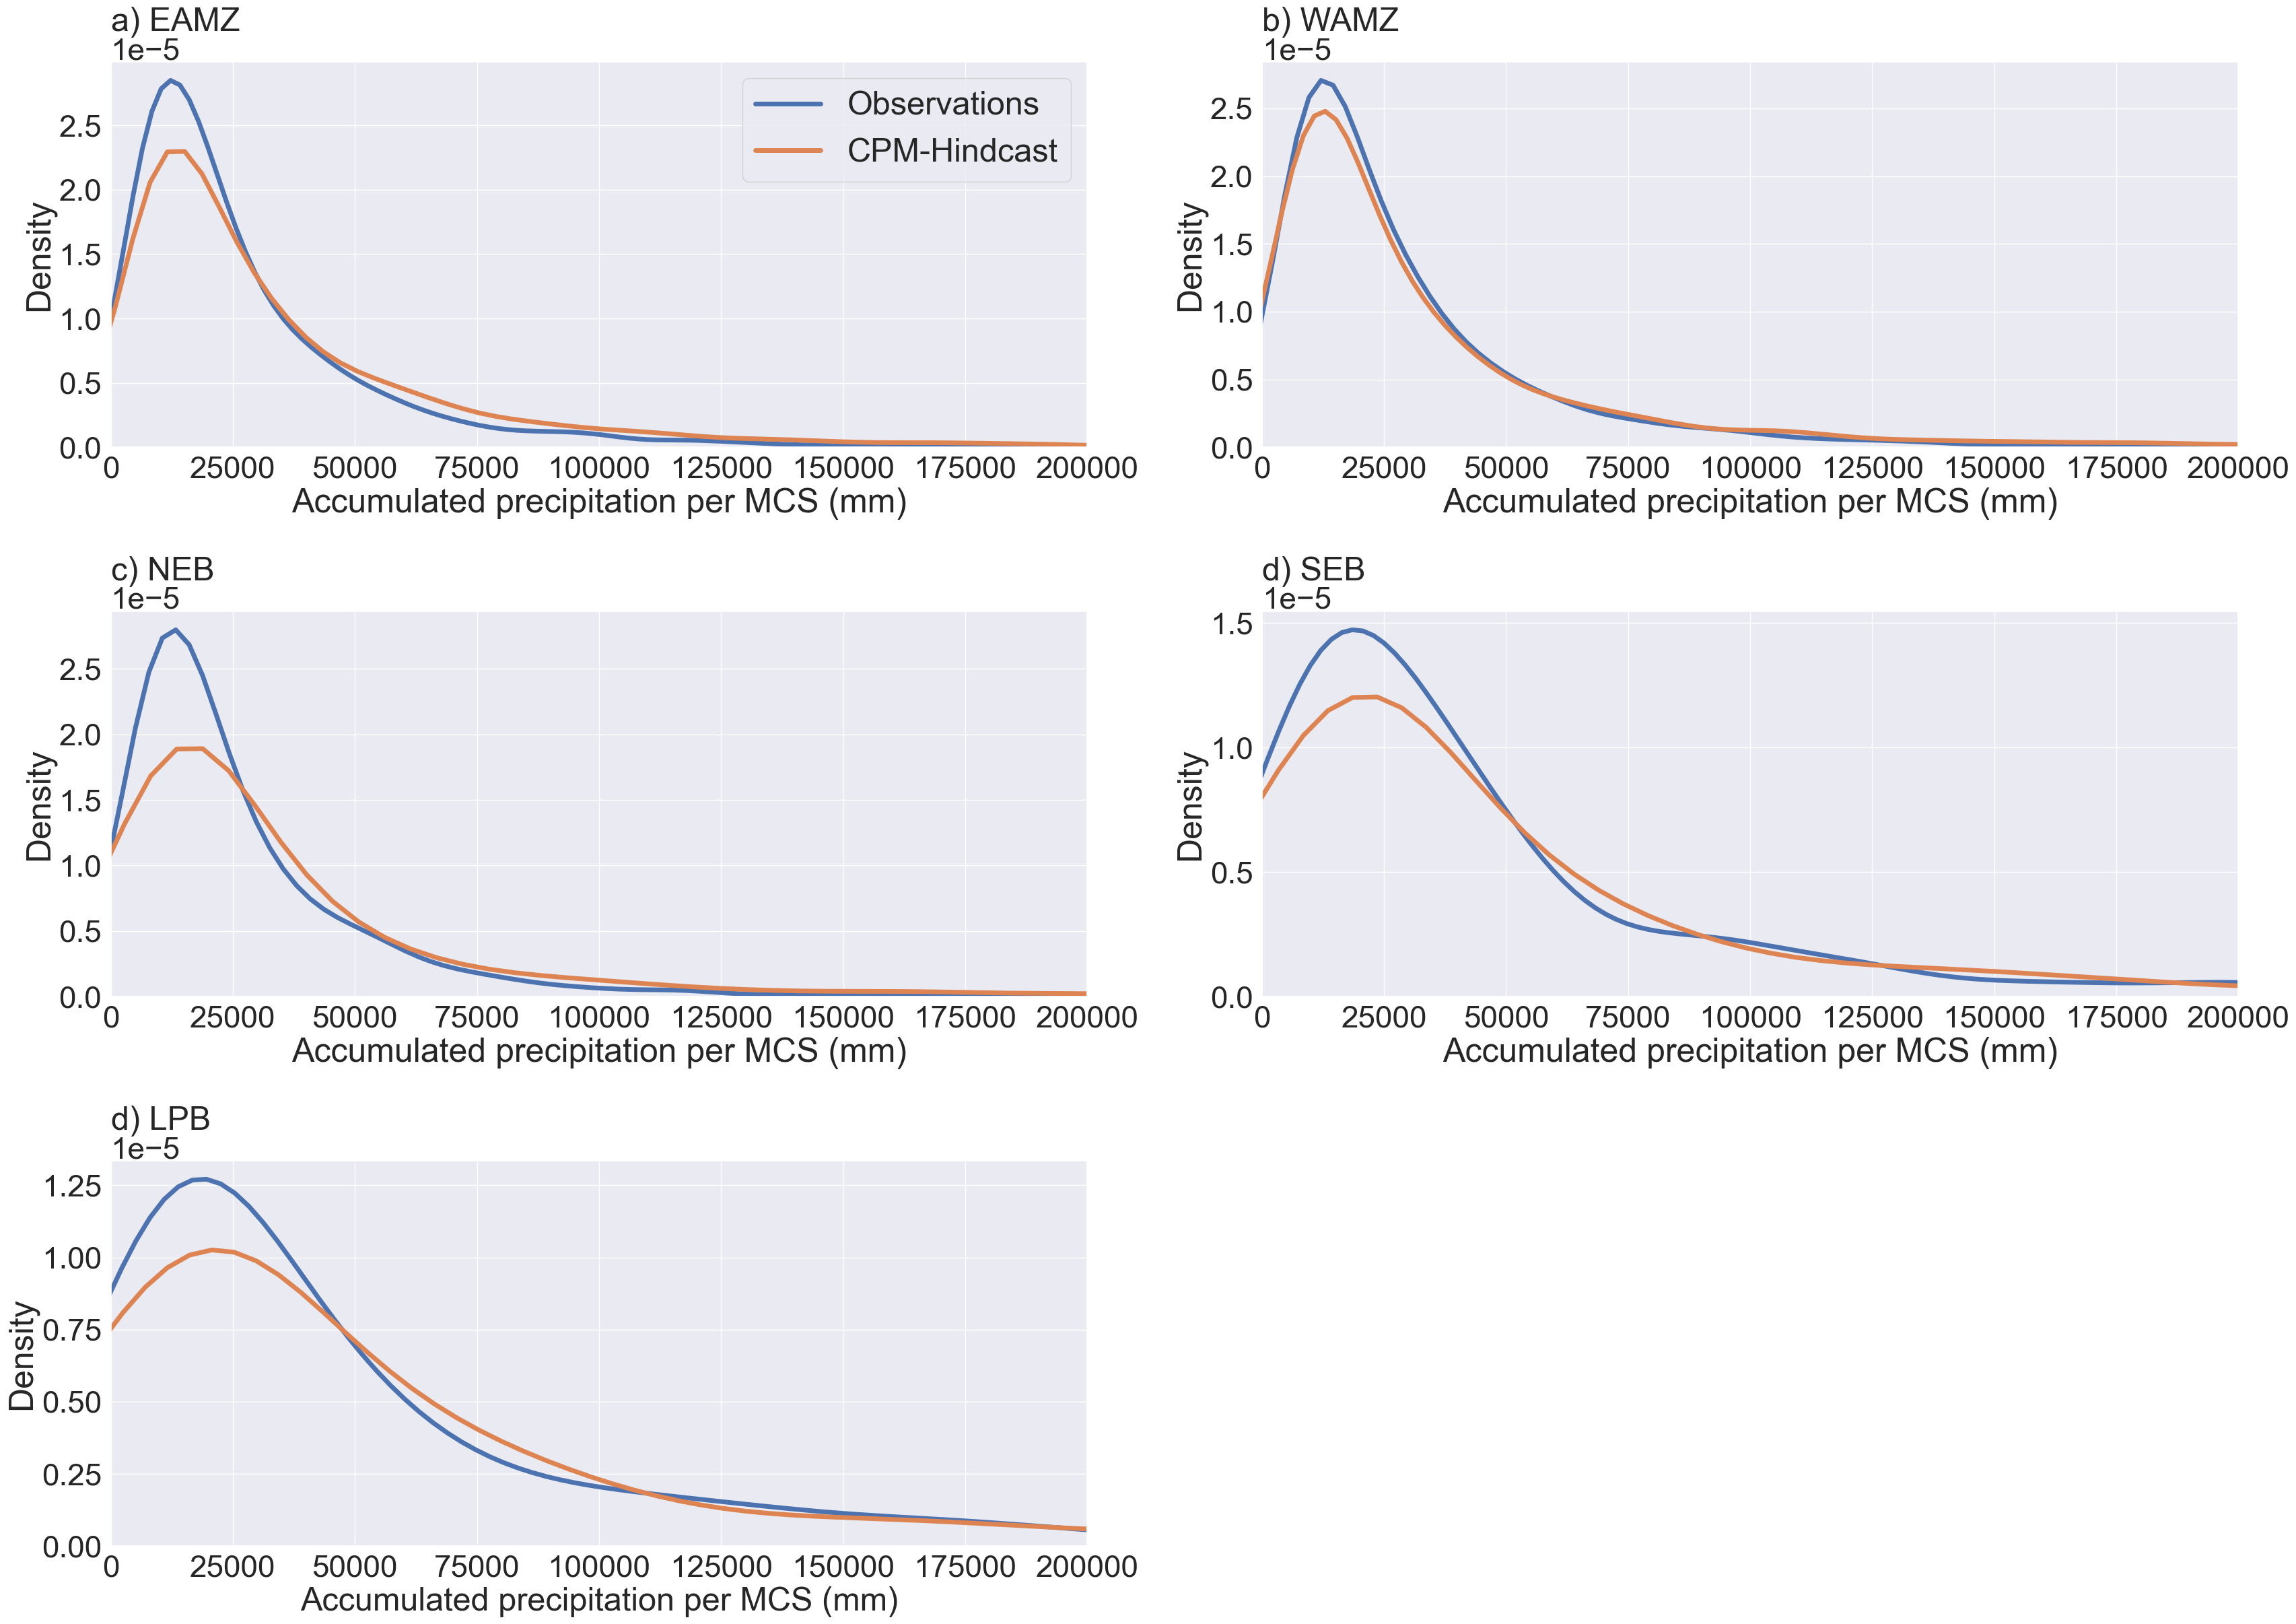

In [65]:

plt.figure(figsize=(35,25))
sns.set(font_scale=3)

ax1 = plt.subplot(3, 2, 1) 
ax1.set_title('a) EAMZ ', loc='left', fontsize= 35)
sns.kdeplot(combined.eamz[(combined.eamz > 0) & (combined.type == 'Observations')], ax=ax1, linewidth=5, label='Observations')
sns.kdeplot(combined.eamz[(combined.eamz > 0) & (combined.type == 'CPM-Hindcast')], ax=ax1, linewidth=5, label='CPM-Hindcast')
ax1.set_xlabel('Accumulated precipitation per MCS (mm)')
ax1.legend(loc='best', fontsize=35)
ax1.set_xlim(0,200000)

ax2 = plt.subplot(3, 2, 2) 
ax2.set_title('b) WAMZ', loc='left', fontsize= 35)
sns.kdeplot(combined.wamz[(combined.wamz > 0) & (combined.type == 'Observations')], ax=ax2, linewidth=5, label='Observations')
sns.kdeplot(combined.wamz[(combined.wamz > 0) & (combined.type == 'CPM-Hindcast')], ax=ax2, linewidth=5, label='CPM-Hindcast')
ax2.set_xlabel('Accumulated precipitation per MCS (mm)')
#ax2.legend(loc='best', fontsize=35)
ax2.set_xlim(0,200000)

ax3 = plt.subplot(3, 2, 3) 
ax3.set_title('c) NEB', loc='left', fontsize= 35)
sns.kdeplot(combined.neb[(combined.neb > 0) & (combined.type == 'Observations')], ax=ax3, linewidth=5, label='Observations')
sns.kdeplot(combined.neb[(combined.neb > 0) & (combined.type == 'CPM-Hindcast')], ax=ax3, linewidth=5, label='CPM-Hindcast')
ax3.set_xlabel('Accumulated precipitation per MCS (mm)')
#ax3.legend(loc='best', fontsize=35)
ax3.set_xlim(0,200000)

ax4 = plt.subplot(3, 2, 4) 
ax4.set_title('d) SEB', loc='left', fontsize= 35)
sns.kdeplot(combined.seb[(combined.seb > 0) & (combined.type == 'Observations')], ax=ax4, linewidth=5, label='Observations')
sns.kdeplot(combined.seb[(combined.seb > 0) & (combined.type == 'CPM-Hindcast')], ax=ax4, linewidth=5, label='CPM-Hindcast')
ax4.set_xlabel('Accumulated precipitation per MCS (mm)')
#ax4.legend(loc='best', fontsize=35)
ax4.set_xlim(0,200000)

ax5 = plt.subplot(3, 2, 5) 
ax5.set_title('d) LPB', loc='left', fontsize= 35)
sns.kdeplot(combined.lpb[(combined.lpb > 0) & (combined.type == 'Observations')], ax=ax5, linewidth=5, label='Observations')
sns.kdeplot(combined.lpb[(combined.lpb > 0) & (combined.type == 'CPM-Hindcast')], ax=ax5, linewidth=5, label='CPM-Hindcast')
ax5.set_xlabel('Accumulated precipitation per MCS (mm)', fontsize=35)
#ax5.legend(loc='best', fontsize=35)
ax5.set_xlim(0,200000)

plt.tight_layout()


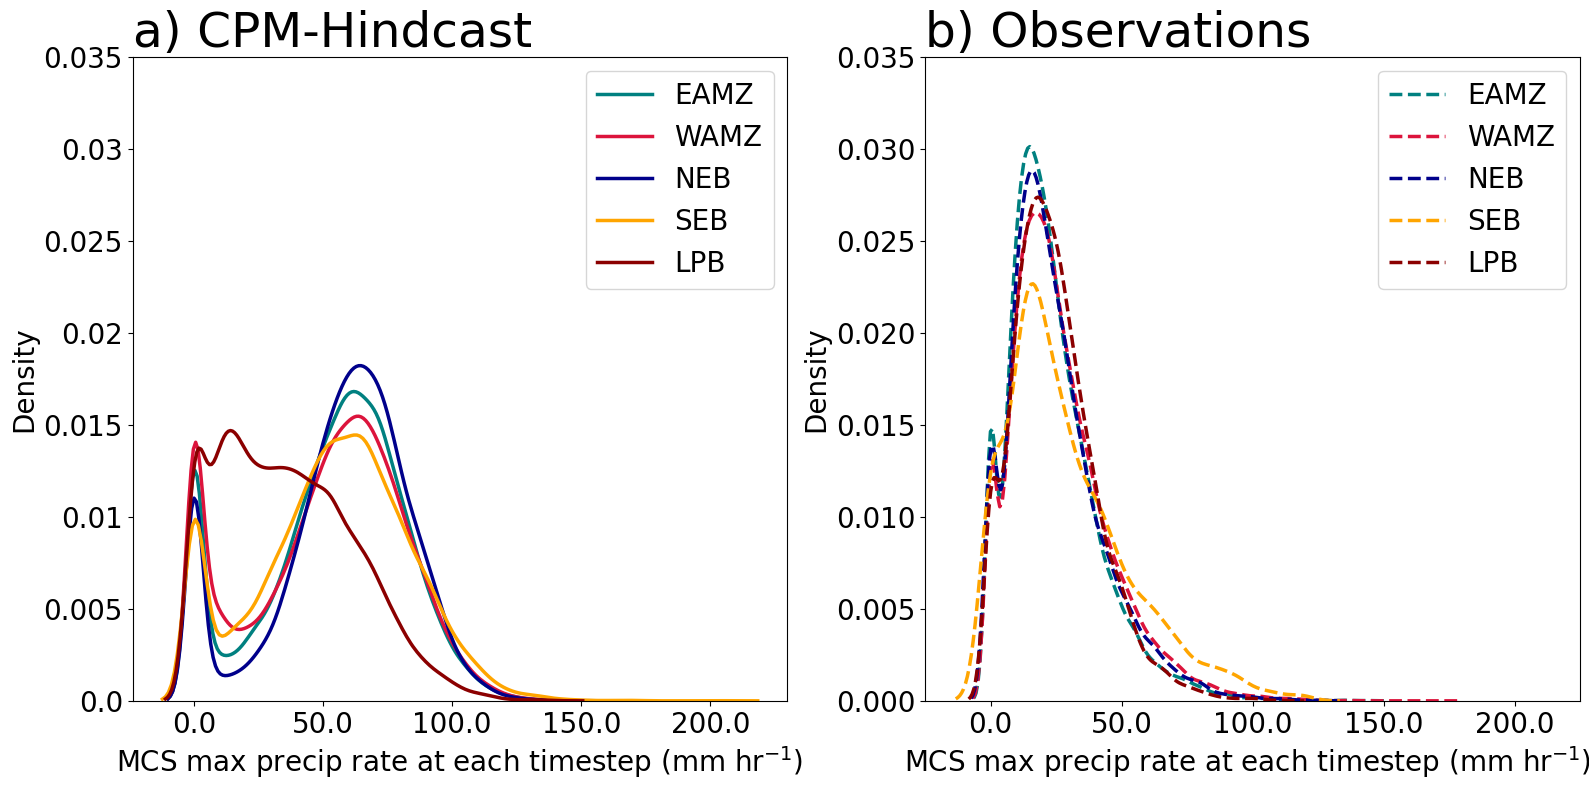

In [144]:
## max precip ##
# --------------
import matplotlib
matplotlib.rc_file_defaults()

f = 20

plt.figure(figsize=(16,8))

ax1 = plt.subplot(1, 2, 1) 
ax1.set_title('a) CPM-Hindcast ', loc='left', fontsize= 35)

sns.kdeplot(eamz_tracks_cpm.max_precip,multiple='layer',color='teal',label='EAMZ', linewidth=2.5, ax=ax1)
sns.kdeplot(wamz_tracks_cpm.max_precip,multiple='layer',color='crimson',label='WAMZ', linewidth=2.5, ax=ax1)
sns.kdeplot(neb_tracks_cpm.max_precip, color='darkblue',multiple='layer',label='NEB', linewidth=2.5, ax=ax1)
sns.kdeplot(seb_tracks_cpm.max_precip, color='orange',multiple='layer',label='SEB', linewidth=2.5, ax=ax1)
sns.kdeplot(lpb_tracks_cpm.max_precip, color='darkred',multiple='layer',label='LPB', linewidth=2.5, ax=ax1)
ax1.set_ylabel('Density', fontsize=f)
ax1.set_xlabel('MCS max precip rate at each timestep (mm hr$^{-1}$)', fontsize=f)
#ax1.set_xlim(0,200)
plt.legend(loc='best', fontsize=f)
ax1.set_ylim(0,0.035)
ax1.set_xticklabels(ax1.get_xticks(), fontsize=f)
ax1.set_yticklabels(ax1.get_yticks(), fontsize=f)



ax2 = plt.subplot(1, 2, 2) 
ax2.set_title('b) Observations ', loc='left', fontsize= 35)

sns.kdeplot(eamz_tracks_obs.max_precip,multiple='layer',color='teal',label='EAMZ', linewidth=2.5, ax=ax2, linestyle='dashed')
sns.kdeplot(wamz_tracks_obs.max_precip,multiple='layer',color='crimson',label='WAMZ', linewidth=2.5, ax=ax2, linestyle='dashed')
sns.kdeplot(neb_tracks_obs.max_precip, color='darkblue',multiple='layer',label='NEB', linewidth=2.5, ax=ax2, linestyle='dashed')
sns.kdeplot(seb_tracks_obs.max_precip, color='orange',multiple='layer',label='SEB', linewidth=2.5, ax=ax2, linestyle='dashed')
sns.kdeplot(lpb_tracks_obs.max_precip, color='darkred',multiple='layer',label='LPB', linewidth=2.5, ax=ax2, linestyle='dashed')
ax2.set_ylabel('Density', fontsize=f)
ax2.set_xlabel('MCS max precip rate at each timestep (mm hr$^{-1}$))', fontsize=f)
ax2.set_ylim(0,0.035)
ax2.set_xlim(-25, 225)
ax2.set_xticklabels(ax2.get_xticks(), fontsize=f)
ax2.set_yticklabels(ax2.get_yticks(), fontsize=f)

plt.legend(loc='best', fontsize=f)

import matplotlib.ticker
from matplotlib.ticker import StrMethodFormatter
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}')) # No decimal places

plt.tight_layout()

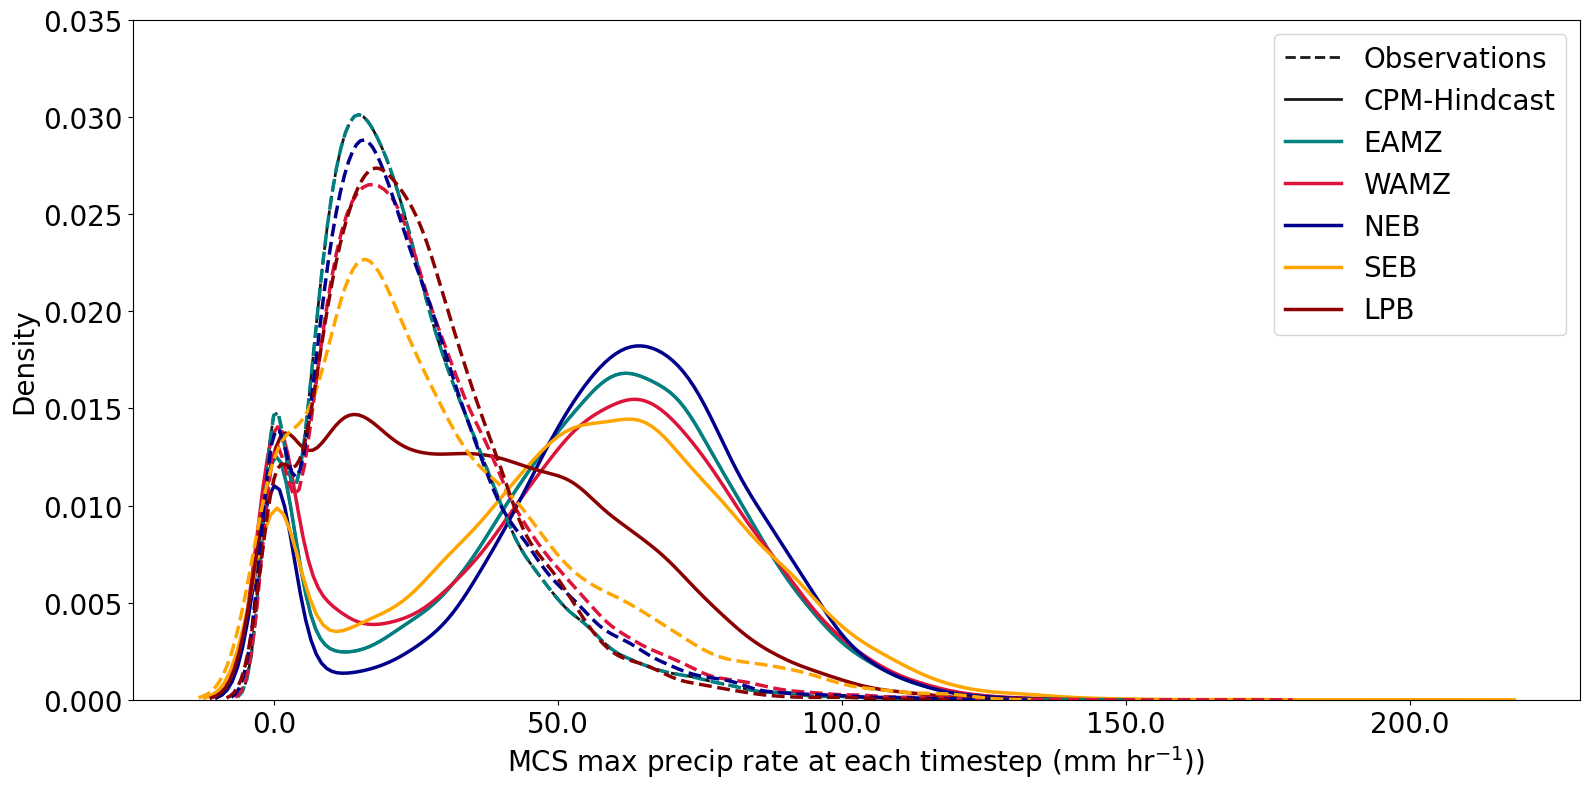

In [146]:
## max precip ##
# --------------
import matplotlib
matplotlib.rc_file_defaults()

f = 20

plt.figure(figsize=(16,8))

ax1 = plt.subplot() 

sns.kdeplot(eamz_tracks_obs.max_precip,multiple='layer',color='k',label='Observations', linewidth=2, ax=ax1, linestyle='dashed')
sns.kdeplot(eamz_tracks_cpm.max_precip,multiple='layer',color='k',label='CPM-Hindcast', linewidth=2, ax=ax1)


sns.kdeplot(eamz_tracks_cpm.max_precip,multiple='layer',color='teal',label='EAMZ', linewidth=2.5, ax=ax1)
sns.kdeplot(wamz_tracks_cpm.max_precip,multiple='layer',color='crimson',label='WAMZ', linewidth=2.5, ax=ax1)
sns.kdeplot(neb_tracks_cpm.max_precip, color='darkblue',multiple='layer',label='NEB', linewidth=2.5, ax=ax1)
sns.kdeplot(seb_tracks_cpm.max_precip, color='orange',multiple='layer',label='SEB', linewidth=2.5, ax=ax1)
sns.kdeplot(lpb_tracks_cpm.max_precip, color='darkred',multiple='layer',label='LPB', linewidth=2.5, ax=ax1)
ax1.set_ylabel('Density', fontsize=f)
ax1.set_xlabel('MCS max precip rate at each timestep (mm hr$^{-1}$))', fontsize=f)
#ax1.set_xlim(0,200)
plt.legend(loc='best', fontsize=f)
ax1.set_ylim(0,0.035)
ax1.set_xticklabels(ax1.get_xticks(), fontsize=f)
ax1.set_yticklabels(ax1.get_yticks(), fontsize=f)

sns.kdeplot(eamz_tracks_obs.max_precip,multiple='layer',color='teal',linewidth=2.5, ax=ax1, linestyle='dashed')
sns.kdeplot(wamz_tracks_obs.max_precip,multiple='layer',color='crimson',linewidth=2.5, ax=ax1, linestyle='dashed')
sns.kdeplot(neb_tracks_obs.max_precip, color='darkblue',multiple='layer',linewidth=2.5, ax=ax1, linestyle='dashed')
sns.kdeplot(seb_tracks_obs.max_precip, color='orange',multiple='layer',linewidth=2.5, ax=ax1, linestyle='dashed')
sns.kdeplot(lpb_tracks_obs.max_precip, color='darkred',multiple='layer',linewidth=2.5, ax=ax1, linestyle='dashed')

plt.legend(loc='best', fontsize=f)

import matplotlib.ticker
from matplotlib.ticker import StrMethodFormatter
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}'))

plt.tight_layout()

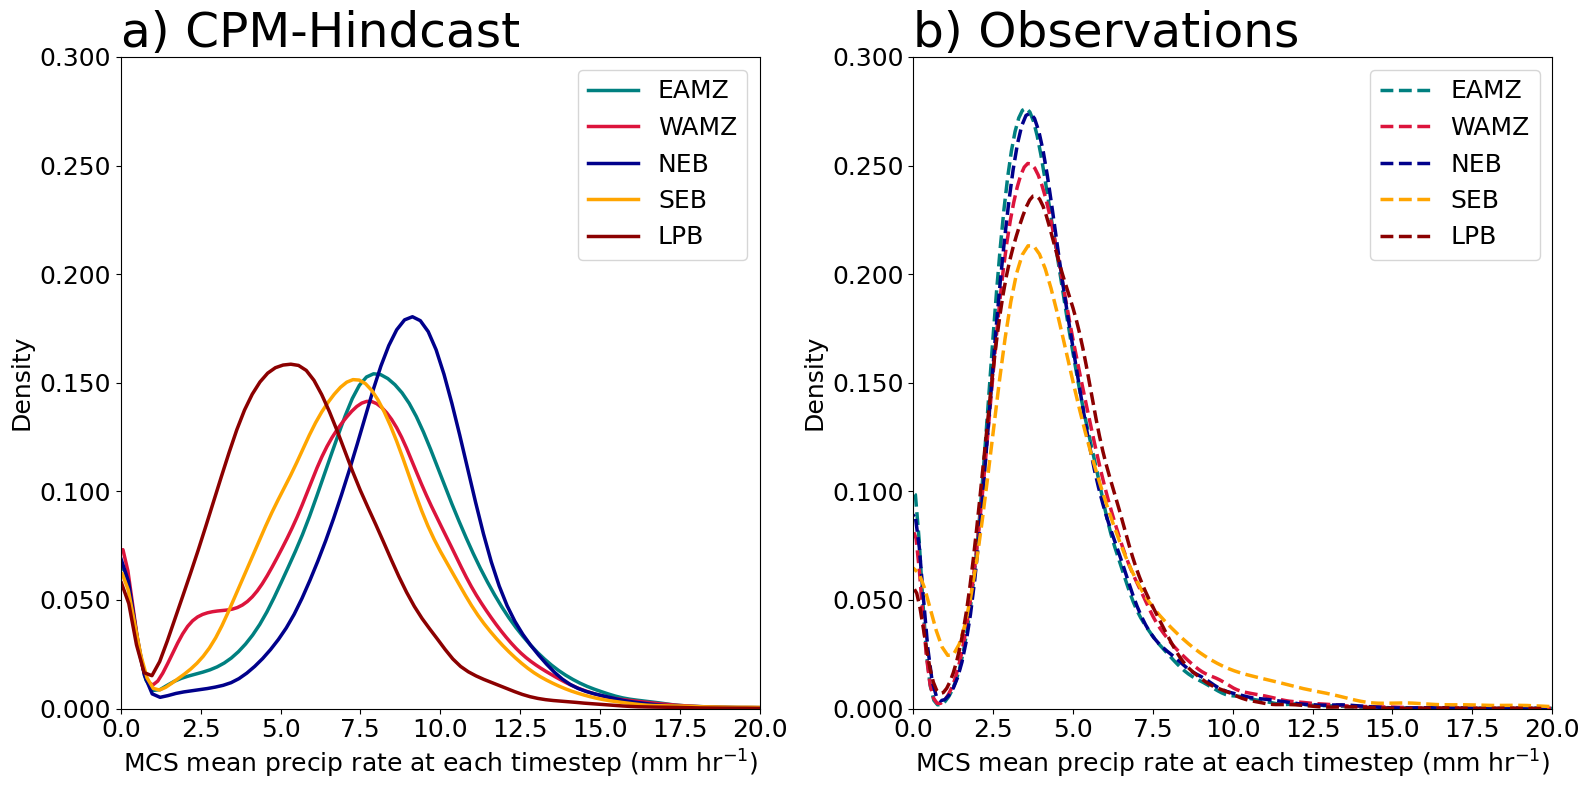

In [149]:
### mean precip ###
## max precip ##
# --------------
import matplotlib
matplotlib.rc_file_defaults()

f = 18

plt.figure(figsize=(16,8))

ax1 = plt.subplot(1, 2, 1) 
ax1.set_title('a) CPM-Hindcast ', loc='left', fontsize= 35)

sns.kdeplot(eamz_tracks_cpm.mean_precip,multiple='layer',color='teal',label='EAMZ', linewidth=2.5, ax=ax1)
sns.kdeplot(wamz_tracks_cpm.mean_precip,multiple='layer',color='crimson',label='WAMZ', linewidth=2.5, ax=ax1)
sns.kdeplot(neb_tracks_cpm.mean_precip, color='darkblue',multiple='layer',label='NEB', linewidth=2.5, ax=ax1)
sns.kdeplot(seb_tracks_cpm.mean_precip, color='orange',multiple='layer',label='SEB', linewidth=2.5, ax=ax1)
sns.kdeplot(lpb_tracks_cpm.mean_precip, color='darkred',multiple='layer',label='LPB', linewidth=2.5, ax=ax1)
ax1.set_ylabel('Density', fontsize=f)
ax1.set_xlabel('MCS mean precip rate at each timestep (mm hr$^{-1}$)', fontsize=f)
plt.legend(loc='best', fontsize=f)
ax1.set_xlim(0,20)
ax1.set_ylim(0,0.3)
ax1.set_xticklabels(ax1.get_xticks(), fontsize=f)
ax1.set_yticklabels(ax1.get_yticks(), fontsize=f)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}')) # No decimal places
#ax1.set_xscale('symlog')



ax2 = plt.subplot(1, 2, 2) 
ax2.set_title('b) Observations ', loc='left', fontsize= 35)

sns.kdeplot(eamz_tracks_obs.mean_precip,multiple='layer',color='teal',label='EAMZ', linewidth=2.5, ax=ax2, linestyle='dashed')
sns.kdeplot(wamz_tracks_obs.mean_precip,multiple='layer',color='crimson',label='WAMZ', linewidth=2.5, ax=ax2, linestyle='dashed')
sns.kdeplot(neb_tracks_obs.mean_precip, color='darkblue',multiple='layer',label='NEB', linewidth=2.5, ax=ax2, linestyle='dashed')
sns.kdeplot(seb_tracks_obs.mean_precip, color='orange',multiple='layer',label='SEB', linewidth=2.5, ax=ax2, linestyle='dashed')
sns.kdeplot(lpb_tracks_obs.mean_precip, color='darkred',multiple='layer',label='LPB', linewidth=2.5, ax=ax2, linestyle='dashed')
ax2.set_ylabel('Density', fontsize=f)
ax2.set_xlabel('MCS mean precip rate at each timestep (mm hr$^{-1}$)', fontsize=f)
ax2.set_ylim(0,0.3)
ax2.set_xlim(0, 20)
ax2.set_xticklabels(ax2.get_xticks(), fontsize=f)
ax2.set_yticklabels(ax2.get_yticks(), fontsize=f)

plt.legend(loc='best', fontsize=f)

import matplotlib.ticker
from matplotlib.ticker import StrMethodFormatter
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}')) # No decimal places

plt.tight_layout()

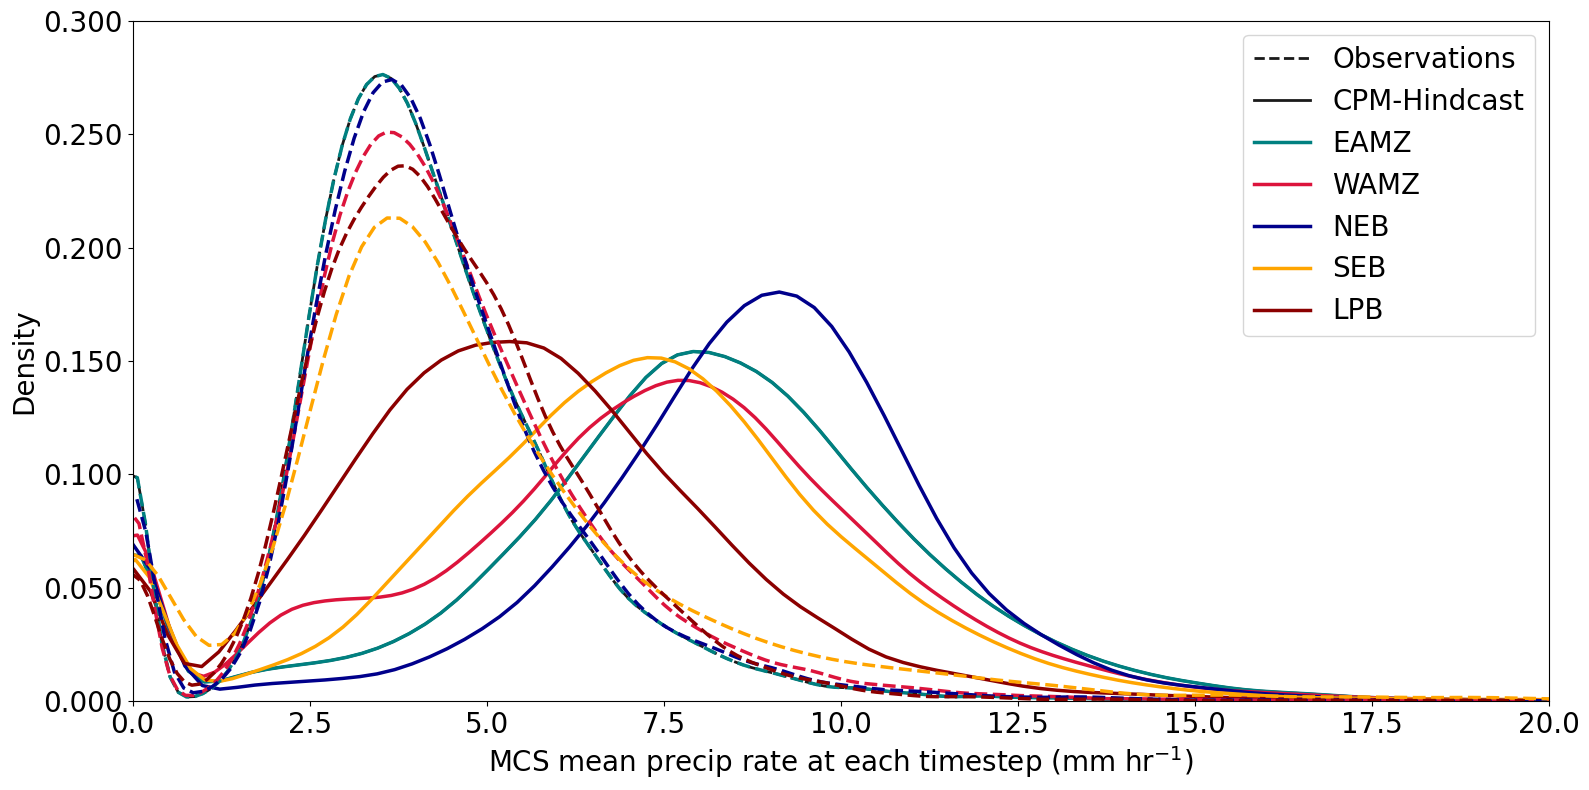

In [152]:
## max precip ##
# --------------
import matplotlib
matplotlib.rc_file_defaults()

f = 20

plt.figure(figsize=(16,8))

ax1 = plt.subplot() 

sns.kdeplot(eamz_tracks_obs.mean_precip,multiple='layer',color='k',label='Observations', linewidth=2, ax=ax1, linestyle='dashed')
sns.kdeplot(eamz_tracks_cpm.mean_precip,multiple='layer',color='k',label='CPM-Hindcast', linewidth=2, ax=ax1)


sns.kdeplot(eamz_tracks_cpm.mean_precip,multiple='layer',color='teal',label='EAMZ', linewidth=2.5, ax=ax1)
sns.kdeplot(wamz_tracks_cpm.mean_precip,multiple='layer',color='crimson',label='WAMZ', linewidth=2.5, ax=ax1)
sns.kdeplot(neb_tracks_cpm.mean_precip, color='darkblue',multiple='layer',label='NEB', linewidth=2.5, ax=ax1)
sns.kdeplot(seb_tracks_cpm.mean_precip, color='orange',multiple='layer',label='SEB', linewidth=2.5, ax=ax1)
sns.kdeplot(lpb_tracks_cpm.mean_precip, color='darkred',multiple='layer',label='LPB', linewidth=2.5, ax=ax1)
ax1.set_ylabel('Density', fontsize=f)
ax1.set_xlabel('MCS mean precip rate at each timestep (mm hr$^{-1}$)', fontsize=f)
ax1.set_xlim(0,20)
plt.legend(loc='best', fontsize=f)
ax1.set_ylim(0,0.3)
ax1.set_xticklabels(ax1.get_xticks(), fontsize=f)
ax1.set_yticklabels(ax1.get_yticks(), fontsize=f)

sns.kdeplot(eamz_tracks_obs.mean_precip,multiple='layer',color='teal',linewidth=2.5, ax=ax1, linestyle='dashed')
sns.kdeplot(wamz_tracks_obs.mean_precip,multiple='layer',color='crimson',linewidth=2.5, ax=ax1, linestyle='dashed')
sns.kdeplot(neb_tracks_obs.mean_precip, color='darkblue',multiple='layer',linewidth=2.5, ax=ax1, linestyle='dashed')
sns.kdeplot(seb_tracks_obs.mean_precip, color='orange',multiple='layer',linewidth=2.5, ax=ax1, linestyle='dashed')
sns.kdeplot(lpb_tracks_obs.mean_precip, color='darkred',multiple='layer',linewidth=2.5, ax=ax1, linestyle='dashed')

plt.legend(loc='best', fontsize=f)

import matplotlib.ticker
from matplotlib.ticker import StrMethodFormatter
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}'))

plt.tight_layout()

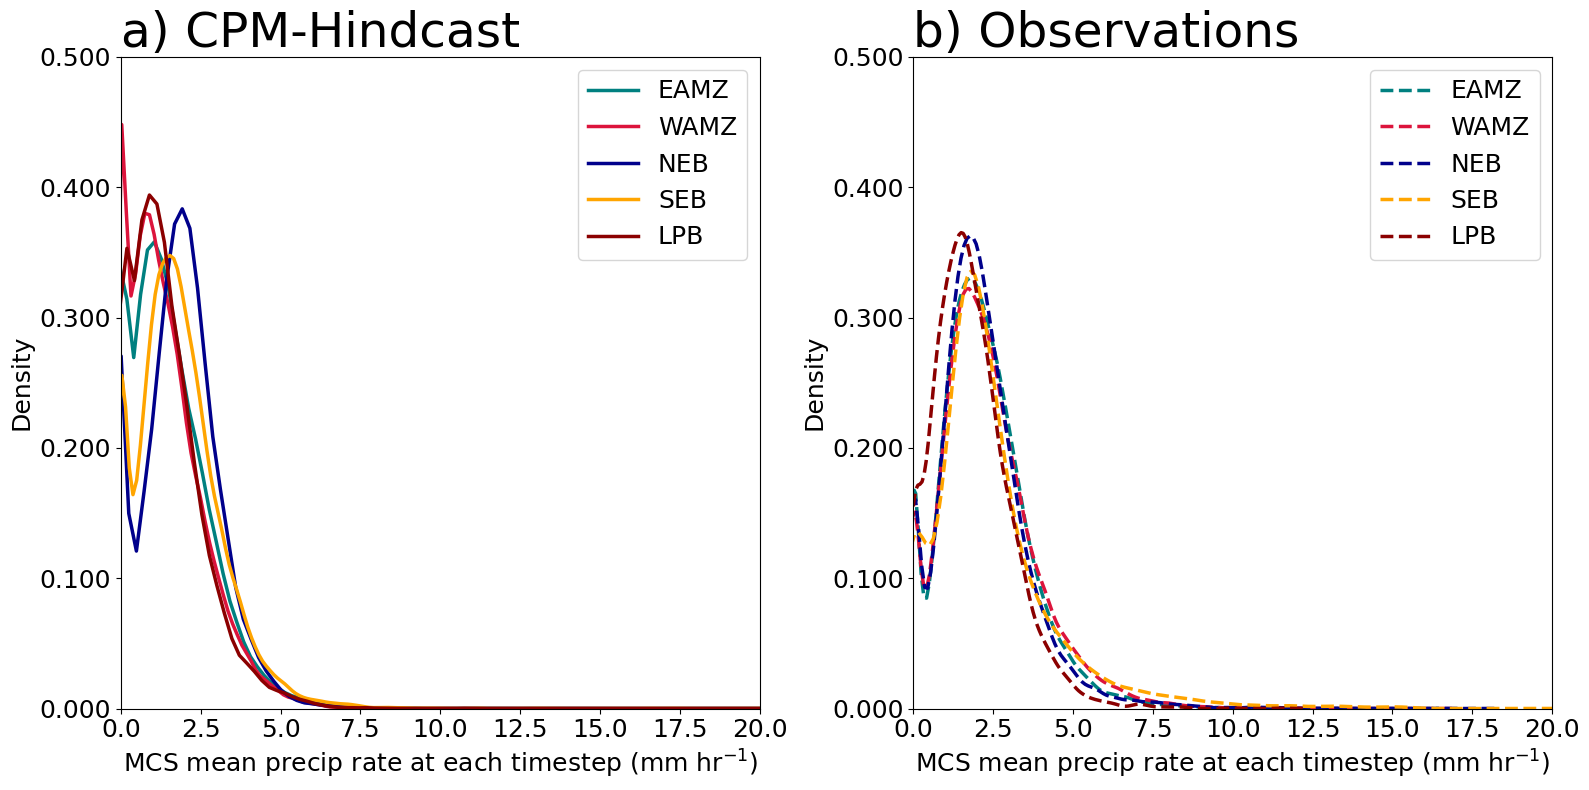

In [159]:
### mean precip ###
## max precip ##
# --------------
import matplotlib
matplotlib.rc_file_defaults()

f = 18

plt.figure(figsize=(16,8))

ax1 = plt.subplot(1, 2, 1) 
ax1.set_title('a) CPM-Hindcast ', loc='left', fontsize= 35)

sns.kdeplot(eamz_tracks_cpm.mean_precip_total,multiple='layer',color='teal',label='EAMZ', linewidth=2.5, ax=ax1)
sns.kdeplot(wamz_tracks_cpm.mean_precip_total,multiple='layer',color='crimson',label='WAMZ', linewidth=2.5, ax=ax1)
sns.kdeplot(neb_tracks_cpm.mean_precip_total, color='darkblue',multiple='layer',label='NEB', linewidth=2.5, ax=ax1)
sns.kdeplot(seb_tracks_cpm.mean_precip_total, color='orange',multiple='layer',label='SEB', linewidth=2.5, ax=ax1)
sns.kdeplot(lpb_tracks_cpm.mean_precip_total, color='darkred',multiple='layer',label='LPB', linewidth=2.5, ax=ax1)
ax1.set_ylabel('Density', fontsize=f)
ax1.set_xlabel('MCS mean precip rate at each timestep (mm hr$^{-1}$)', fontsize=f)
plt.legend(loc='best', fontsize=f)
ax1.set_xlim(0,20)
ax1.set_ylim(0,0.5)
ax1.set_xticklabels(ax1.get_xticks(), fontsize=f)
ax1.set_yticklabels(ax1.get_yticks(), fontsize=f)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}')) # No decimal places
#ax1.set_xscale('symlog')



ax2 = plt.subplot(1, 2, 2) 
ax2.set_title('b) Observations ', loc='left', fontsize= 35)

sns.kdeplot(eamz_tracks_obs.mean_precip_total,multiple='layer',color='teal',label='EAMZ', linewidth=2.5, ax=ax2, linestyle='dashed')
sns.kdeplot(wamz_tracks_obs.mean_precip_total,multiple='layer',color='crimson',label='WAMZ', linewidth=2.5, ax=ax2, linestyle='dashed')
sns.kdeplot(neb_tracks_obs.mean_precip_total, color='darkblue',multiple='layer',label='NEB', linewidth=2.5, ax=ax2, linestyle='dashed')
sns.kdeplot(seb_tracks_obs.mean_precip_total, color='orange',multiple='layer',label='SEB', linewidth=2.5, ax=ax2, linestyle='dashed')
sns.kdeplot(lpb_tracks_obs.mean_precip_total, color='darkred',multiple='layer',label='LPB', linewidth=2.5, ax=ax2, linestyle='dashed')
ax2.set_ylabel('Density', fontsize=f)
ax2.set_xlabel('MCS mean precip rate at each timestep (mm hr$^{-1}$)', fontsize=f)
ax2.set_ylim(0,0.5)
ax2.set_xlim(0, 20)
ax2.set_xticklabels(ax2.get_xticks(), fontsize=f)
ax2.set_yticklabels(ax2.get_yticks(), fontsize=f)

plt.legend(loc='best', fontsize=f)

import matplotlib.ticker
from matplotlib.ticker import StrMethodFormatter
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}')) # No decimal places

plt.tight_layout()

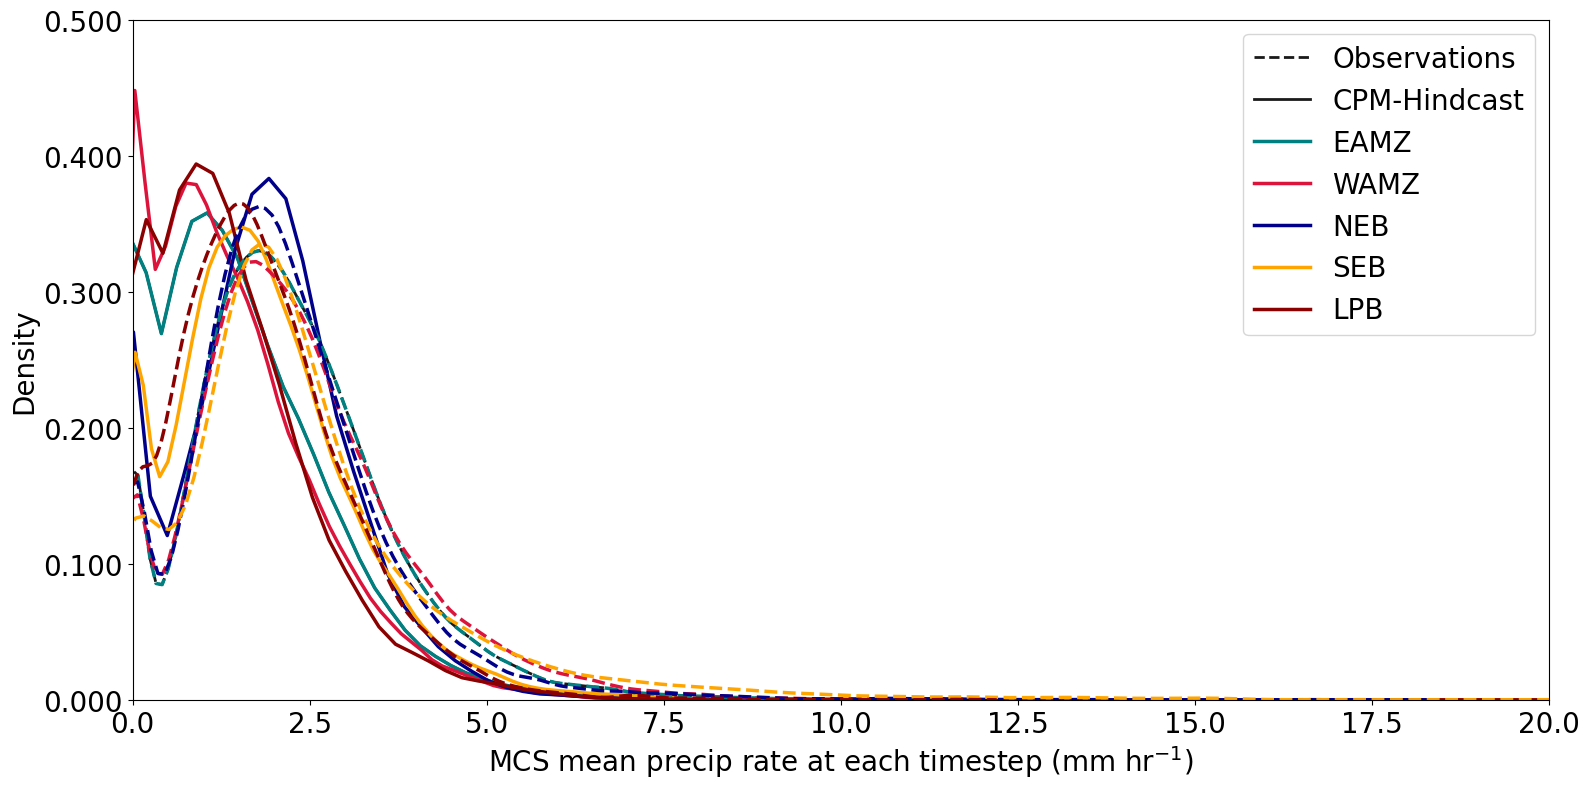

In [160]:
## mean precip ##
# --------------
import matplotlib
matplotlib.rc_file_defaults()

f = 20

plt.figure(figsize=(16,8))

ax1 = plt.subplot() 

sns.kdeplot(eamz_tracks_obs.mean_precip_total,multiple='layer',color='k',label='Observations', linewidth=2, ax=ax1, linestyle='dashed')
sns.kdeplot(eamz_tracks_cpm.mean_precip_total,multiple='layer',color='k',label='CPM-Hindcast', linewidth=2, ax=ax1)


sns.kdeplot(eamz_tracks_cpm.mean_precip_total,multiple='layer',color='teal',label='EAMZ', linewidth=2.5, ax=ax1)
sns.kdeplot(wamz_tracks_cpm.mean_precip_total,multiple='layer',color='crimson',label='WAMZ', linewidth=2.5, ax=ax1)
sns.kdeplot(neb_tracks_cpm.mean_precip_total, color='darkblue',multiple='layer',label='NEB', linewidth=2.5, ax=ax1)
sns.kdeplot(seb_tracks_cpm.mean_precip_total, color='orange',multiple='layer',label='SEB', linewidth=2.5, ax=ax1)
sns.kdeplot(lpb_tracks_cpm.mean_precip_total, color='darkred',multiple='layer',label='LPB', linewidth=2.5, ax=ax1)
ax1.set_ylabel('Density', fontsize=f)
ax1.set_xlabel('MCS mean precip rate at each timestep (mm hr$^{-1}$)', fontsize=f)
ax1.set_xlim(0,20)
plt.legend(loc='best', fontsize=f)
ax1.set_ylim(0,0.5)
ax1.set_xticklabels(ax1.get_xticks(), fontsize=f)
ax1.set_yticklabels(ax1.get_yticks(), fontsize=f)

sns.kdeplot(eamz_tracks_obs.mean_precip_total,multiple='layer',color='teal',linewidth=2.5, ax=ax1, linestyle='dashed')
sns.kdeplot(wamz_tracks_obs.mean_precip_total,multiple='layer',color='crimson',linewidth=2.5, ax=ax1, linestyle='dashed')
sns.kdeplot(neb_tracks_obs.mean_precip_total, color='darkblue',multiple='layer',linewidth=2.5, ax=ax1, linestyle='dashed')
sns.kdeplot(seb_tracks_obs.mean_precip_total, color='orange',multiple='layer',linewidth=2.5, ax=ax1, linestyle='dashed')
sns.kdeplot(lpb_tracks_obs.mean_precip_total, color='darkred',multiple='layer',linewidth=2.5, ax=ax1, linestyle='dashed')

plt.legend(loc='best', fontsize=f)

import matplotlib.ticker
from matplotlib.ticker import StrMethodFormatter
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}'))

plt.tight_layout()

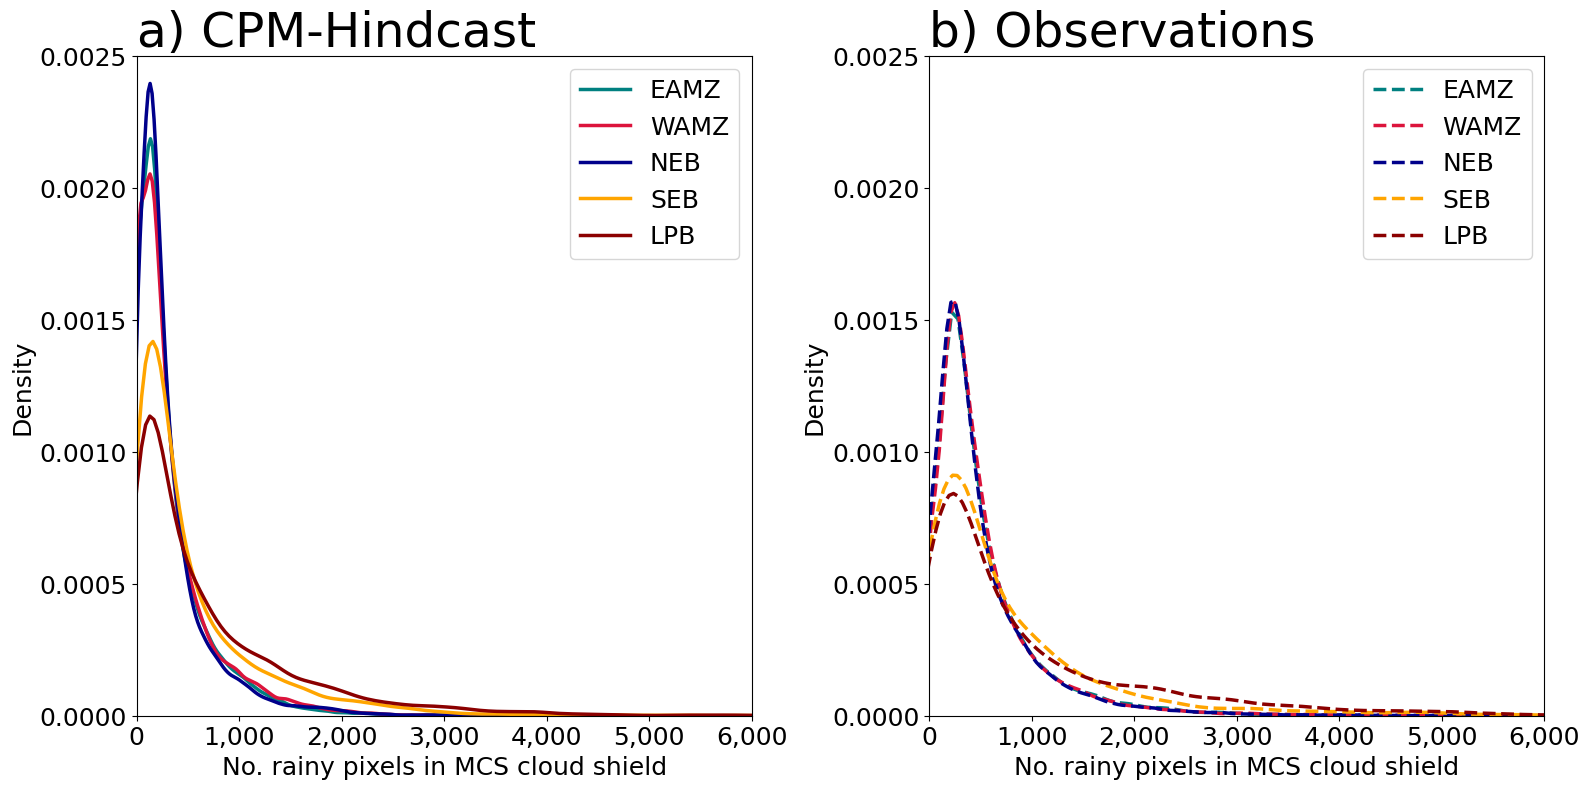

In [169]:
### rain flag ###
## max precip ##
# --------------
import matplotlib
matplotlib.rc_file_defaults()

f = 18

plt.figure(figsize=(16,8))

ax1 = plt.subplot(1, 2, 1) 
ax1.set_title('a) CPM-Hindcast ', loc='left', fontsize= 35)

sns.kdeplot(eamz_tracks_cpm.rain_flag,multiple='layer',color='teal',label='EAMZ', linewidth=2.5, ax=ax1)
sns.kdeplot(wamz_tracks_cpm.rain_flag,multiple='layer',color='crimson',label='WAMZ', linewidth=2.5, ax=ax1)
sns.kdeplot(neb_tracks_cpm.rain_flag, color='darkblue',multiple='layer',label='NEB', linewidth=2.5, ax=ax1)
sns.kdeplot(seb_tracks_cpm.rain_flag, color='orange',multiple='layer',label='SEB', linewidth=2.5, ax=ax1)
sns.kdeplot(lpb_tracks_cpm.rain_flag, color='darkred',multiple='layer',label='LPB', linewidth=2.5, ax=ax1)
ax1.set_ylabel('Density', fontsize=f)
ax1.set_xlabel('No. rainy pixels in MCS cloud shield', fontsize=f)
plt.legend(loc='best', fontsize=f)
ax1.set_xlim(0,6000)
ax1.set_ylim(0,0.0025)
ax1.set_xticklabels(ax1.get_xticks(), fontsize=f)
ax1.set_yticklabels(ax1.get_yticks(), fontsize=f)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.4f}')) # No decimal places
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) # No decimal places

#ax1.set_xscale('symlog')



ax2 = plt.subplot(1, 2, 2) 
ax2.set_title('b) Observations ', loc='left', fontsize= 35)

sns.kdeplot(eamz_tracks_obs.rain_flag,multiple='layer',color='teal',label='EAMZ', linewidth=2.5, ax=ax2, linestyle='dashed')
sns.kdeplot(wamz_tracks_obs.rain_flag,multiple='layer',color='crimson',label='WAMZ', linewidth=2.5, ax=ax2, linestyle='dashed')
sns.kdeplot(neb_tracks_obs.rain_flag, color='darkblue',multiple='layer',label='NEB', linewidth=2.5, ax=ax2, linestyle='dashed')
sns.kdeplot(seb_tracks_obs.rain_flag, color='orange',multiple='layer',label='SEB', linewidth=2.5, ax=ax2, linestyle='dashed')
sns.kdeplot(lpb_tracks_obs.rain_flag, color='darkred',multiple='layer',label='LPB', linewidth=2.5, ax=ax2, linestyle='dashed')
ax2.set_ylabel('Density', fontsize=f)
ax2.set_xlabel('No. rainy pixels in MCS cloud shield', fontsize=f)
ax2.set_ylim(0,0.0025)
ax2.set_xlim(0, 6000)
ax2.set_xticklabels(ax2.get_xticks(), fontsize=f)
ax2.set_yticklabels(ax2.get_yticks(), fontsize=f)

plt.legend(loc='best', fontsize=f)

import matplotlib.ticker
from matplotlib.ticker import StrMethodFormatter
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.4f}')) # No decimal places
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) # No decimal places


plt.tight_layout()

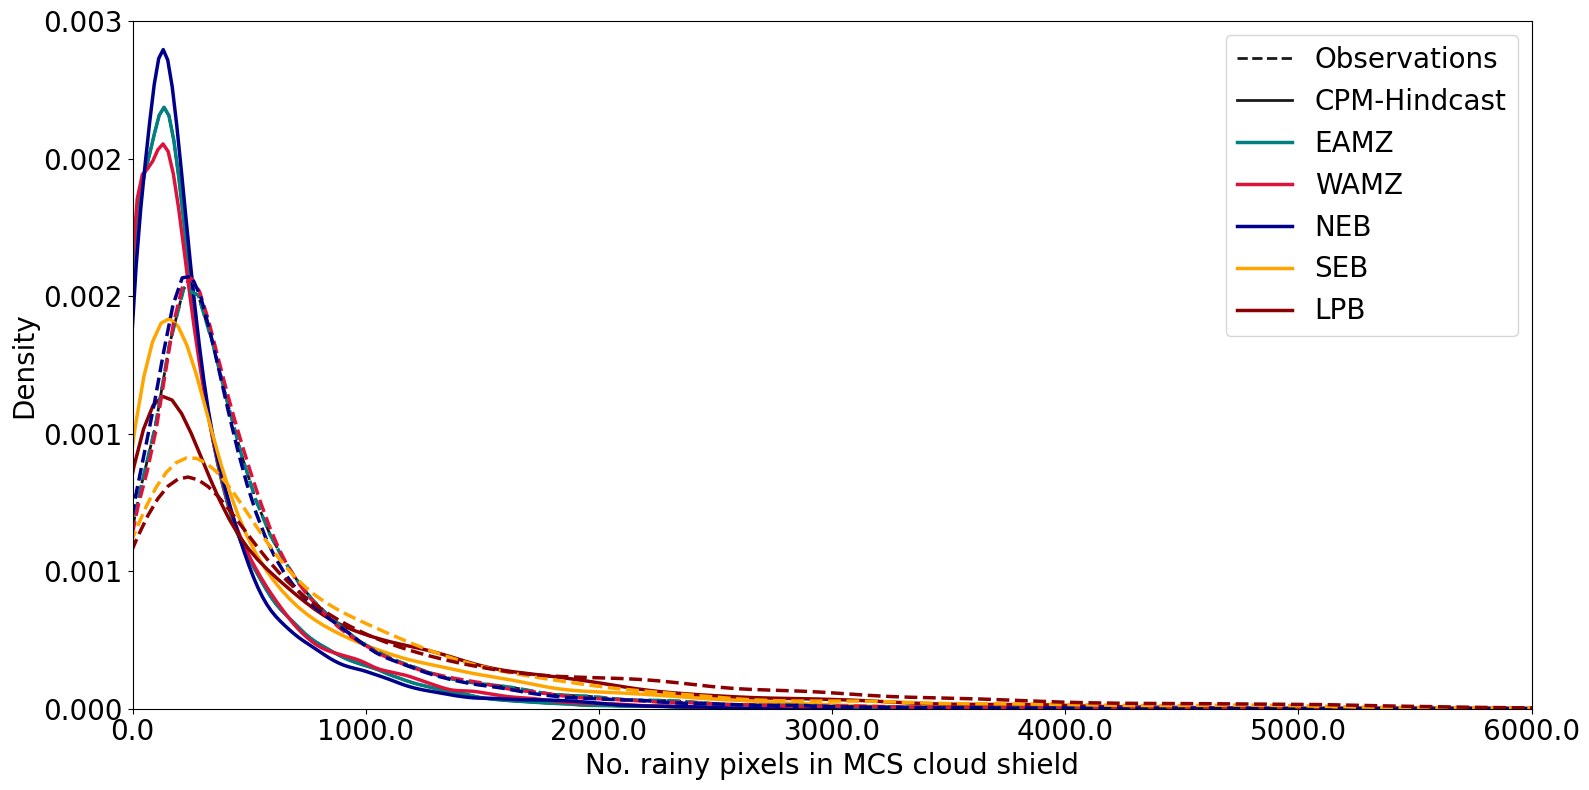

In [170]:
## no. rainy pixels ##
# --------------
import matplotlib
matplotlib.rc_file_defaults()

f = 20

plt.figure(figsize=(16,8))

ax1 = plt.subplot() 

sns.kdeplot(eamz_tracks_obs.rain_flag,multiple='layer',color='k',label='Observations', linewidth=2, ax=ax1, linestyle='dashed')
sns.kdeplot(eamz_tracks_cpm.rain_flag,multiple='layer',color='k',label='CPM-Hindcast', linewidth=2, ax=ax1)


sns.kdeplot(eamz_tracks_cpm.rain_flag,multiple='layer',color='teal',label='EAMZ', linewidth=2.5, ax=ax1)
sns.kdeplot(wamz_tracks_cpm.rain_flag,multiple='layer',color='crimson',label='WAMZ', linewidth=2.5, ax=ax1)
sns.kdeplot(neb_tracks_cpm.rain_flag, color='darkblue',multiple='layer',label='NEB', linewidth=2.5, ax=ax1)
sns.kdeplot(seb_tracks_cpm.rain_flag, color='orange',multiple='layer',label='SEB', linewidth=2.5, ax=ax1)
sns.kdeplot(lpb_tracks_cpm.rain_flag, color='darkred',multiple='layer',label='LPB', linewidth=2.5, ax=ax1)
ax1.set_ylabel('Density', fontsize=f)
ax1.set_xlabel('No. rainy pixels in MCS cloud shield', fontsize=f)
ax1.set_xlim(0,6000)
plt.legend(loc='best', fontsize=f)
ax1.set_ylim(0,0.0025)
ax1.set_xticklabels(ax1.get_xticks(), fontsize=f)
ax1.set_yticklabels(ax1.get_yticks(), fontsize=f)

sns.kdeplot(eamz_tracks_obs.rain_flag,multiple='layer',color='teal',linewidth=2.5, ax=ax1, linestyle='dashed')
sns.kdeplot(wamz_tracks_obs.rain_flag,multiple='layer',color='crimson',linewidth=2.5, ax=ax1, linestyle='dashed')
sns.kdeplot(neb_tracks_obs.rain_flag, color='darkblue',multiple='layer',linewidth=2.5, ax=ax1, linestyle='dashed')
sns.kdeplot(seb_tracks_obs.rain_flag, color='orange',multiple='layer',linewidth=2.5, ax=ax1, linestyle='dashed')
sns.kdeplot(lpb_tracks_obs.rain_flag, color='darkred',multiple='layer',linewidth=2.5, ax=ax1, linestyle='dashed')

plt.legend(loc='best', fontsize=f)

import matplotlib.ticker
from matplotlib.ticker import StrMethodFormatter
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}'))

plt.tight_layout()

**Divde no. rainy pixels at each timestep by the total pixels of the cloud shield (num)**

In [200]:
i = 0
dataframes = [eamz_tracks_cpm, wamz_tracks_cpm, neb_tracks_cpm, seb_tracks_cpm, lpb_tracks_cpm, eamz_tracks_obs, wamz_tracks_obs, neb_tracks_obs, seb_tracks_obs, lpb_tracks_obs]

for file in dataframes:
    file['rainy_pixel_proportion'] = (file['rain_flag'] / file['num'])*100
    file['heavy_rainy_pixel_proportion'] = (file['heavy_rain_flag'] / file['num'])*100
    file['extreme_rainy_pixel_proportion'] = (file['extreme_rain_flag'] / file['num'])*100

        frame  idx      hdim_1      hdim_2    num  threshold_value  feature  \
31          2  124  717.927725  695.554445  21717              240       32   
43          3   83  707.899711  676.785055  27282              240       44   
55          4   92  729.683324  682.654579  21082              240       56   
69          5   78  734.215714  681.560944  20502              240       70   
80          6   86  739.736455  681.749094  20604              240       81   
...       ...  ...         ...         ...    ...              ...      ...   
102366   8750  103  828.651586  589.808113  14720              240   102367   
102379   8751  135  826.919365  590.648755  15152              240   102380   
102393   8752  206  830.627519  591.712584  14651              240   102394   
102406   8753  203  833.153969  596.969103  16238              240   102407   
102420   8754  213  834.715638  602.627354  16652              240   102421   

                       time              timestr   

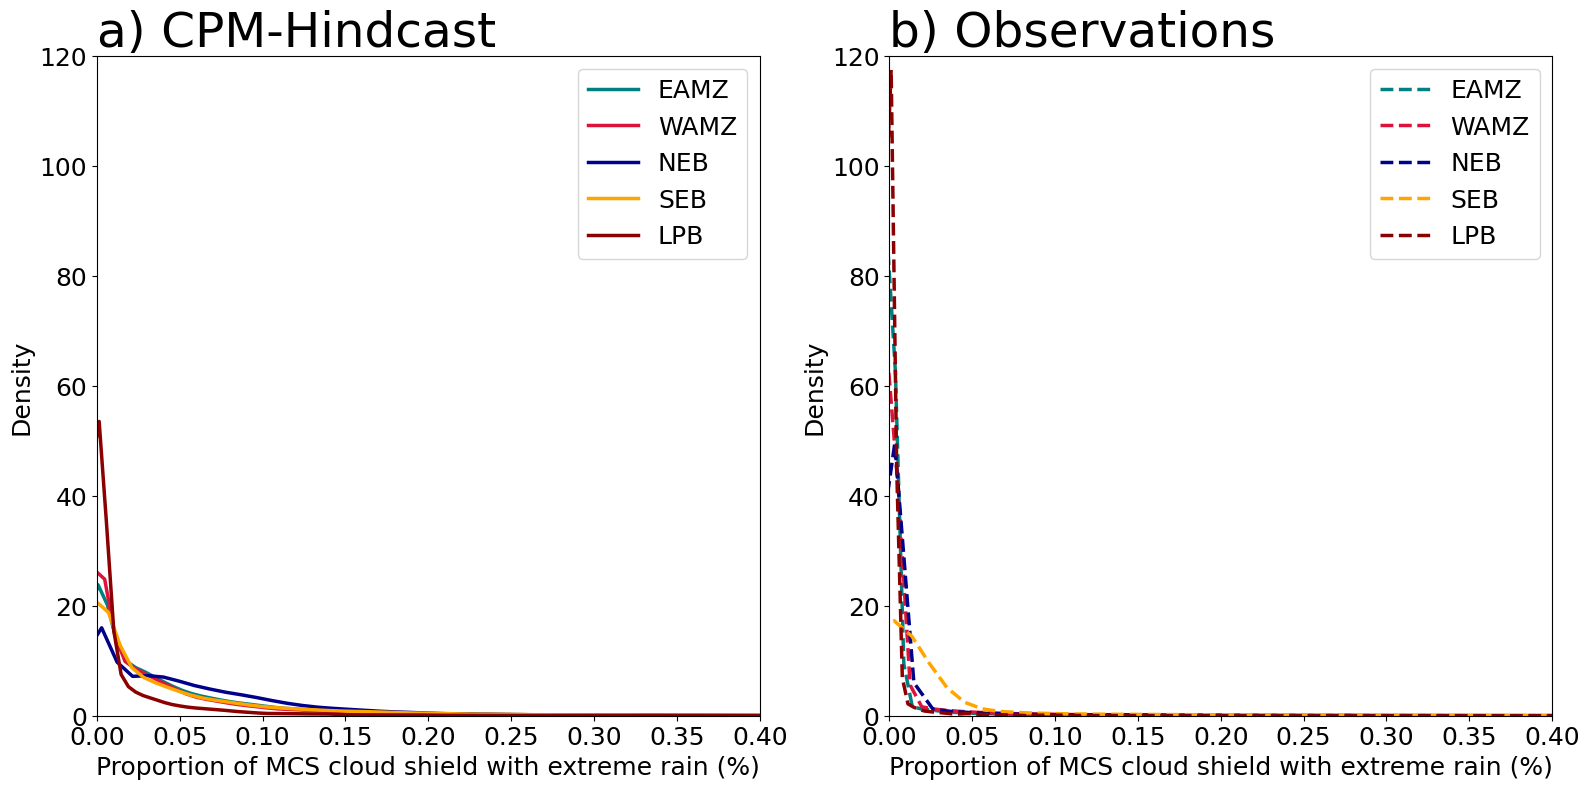

In [226]:
### proportion of cloud shield with rain ###
# --------------
import matplotlib
matplotlib.rc_file_defaults()

f = 18

plt.figure(figsize=(16,8))

ax1 = plt.subplot(1, 2, 1) 
ax1.set_title('a) CPM-Hindcast ', loc='left', fontsize= 35)

sns.kdeplot(eamz_tracks_cpm.extreme_rainy_pixel_proportion,multiple='layer',color='teal',label='EAMZ', linewidth=2.5, ax=ax1)
sns.kdeplot(wamz_tracks_cpm.extreme_rainy_pixel_proportion,multiple='layer',color='crimson',label='WAMZ', linewidth=2.5, ax=ax1)
sns.kdeplot(neb_tracks_cpm.extreme_rainy_pixel_proportion, color='darkblue',multiple='layer',label='NEB', linewidth=2.5, ax=ax1)
sns.kdeplot(seb_tracks_cpm.extreme_rainy_pixel_proportion, color='orange',multiple='layer',label='SEB', linewidth=2.5, ax=ax1)
sns.kdeplot(lpb_tracks_cpm.extreme_rainy_pixel_proportion, color='darkred',multiple='layer',label='LPB', linewidth=2.5, ax=ax1)
ax1.set_ylabel('Density', fontsize=f)
ax1.set_xlabel('Proportion of MCS cloud shield with extreme rain (%)', fontsize=f)
plt.legend(loc='best', fontsize=f)
ax1.set_xlim(0,0.4)
ax1.set_ylim(0,120)
ax1.set_xticklabels(ax1.get_xticks(), fontsize=f)
ax1.set_yticklabels(ax1.get_yticks(), fontsize=f)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) # No decimal places
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) # No decimal places

#ax1.set_xscale('symlog')



ax2 = plt.subplot(1, 2, 2) 
ax2.set_title('b) Observations ', loc='left', fontsize= 35)

sns.kdeplot(eamz_tracks_obs.extreme_rainy_pixel_proportion,multiple='layer',color='teal',label='EAMZ', linewidth=2.5, ax=ax2, linestyle='dashed')
sns.kdeplot(wamz_tracks_obs.extreme_rainy_pixel_proportion,multiple='layer',color='crimson',label='WAMZ', linewidth=2.5, ax=ax2, linestyle='dashed')
sns.kdeplot(neb_tracks_obs.extreme_rainy_pixel_proportion, color='darkblue',multiple='layer',label='NEB', linewidth=2.5, ax=ax2, linestyle='dashed')
sns.kdeplot(seb_tracks_obs.extreme_rainy_pixel_proportion, color='orange',multiple='layer',label='SEB', linewidth=2.5, ax=ax2, linestyle='dashed')
sns.kdeplot(lpb_tracks_obs.extreme_rainy_pixel_proportion, color='darkred',multiple='layer',label='LPB', linewidth=2.5, ax=ax2, linestyle='dashed')
ax2.set_ylabel('Density', fontsize=f)
ax2.set_xlabel('Proportion of MCS cloud shield with extreme rain (%)', fontsize=f)
ax2.set_ylim(0,120)
ax2.set_xlim(0, 0.4)
ax2.set_xticklabels(ax2.get_xticks(), fontsize=f)
ax2.set_yticklabels(ax2.get_yticks(), fontsize=f)

plt.legend(loc='best', fontsize=f)

import matplotlib.ticker
from matplotlib.ticker import StrMethodFormatter
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) # No decimal places
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) # No decimal places


plt.tight_layout()

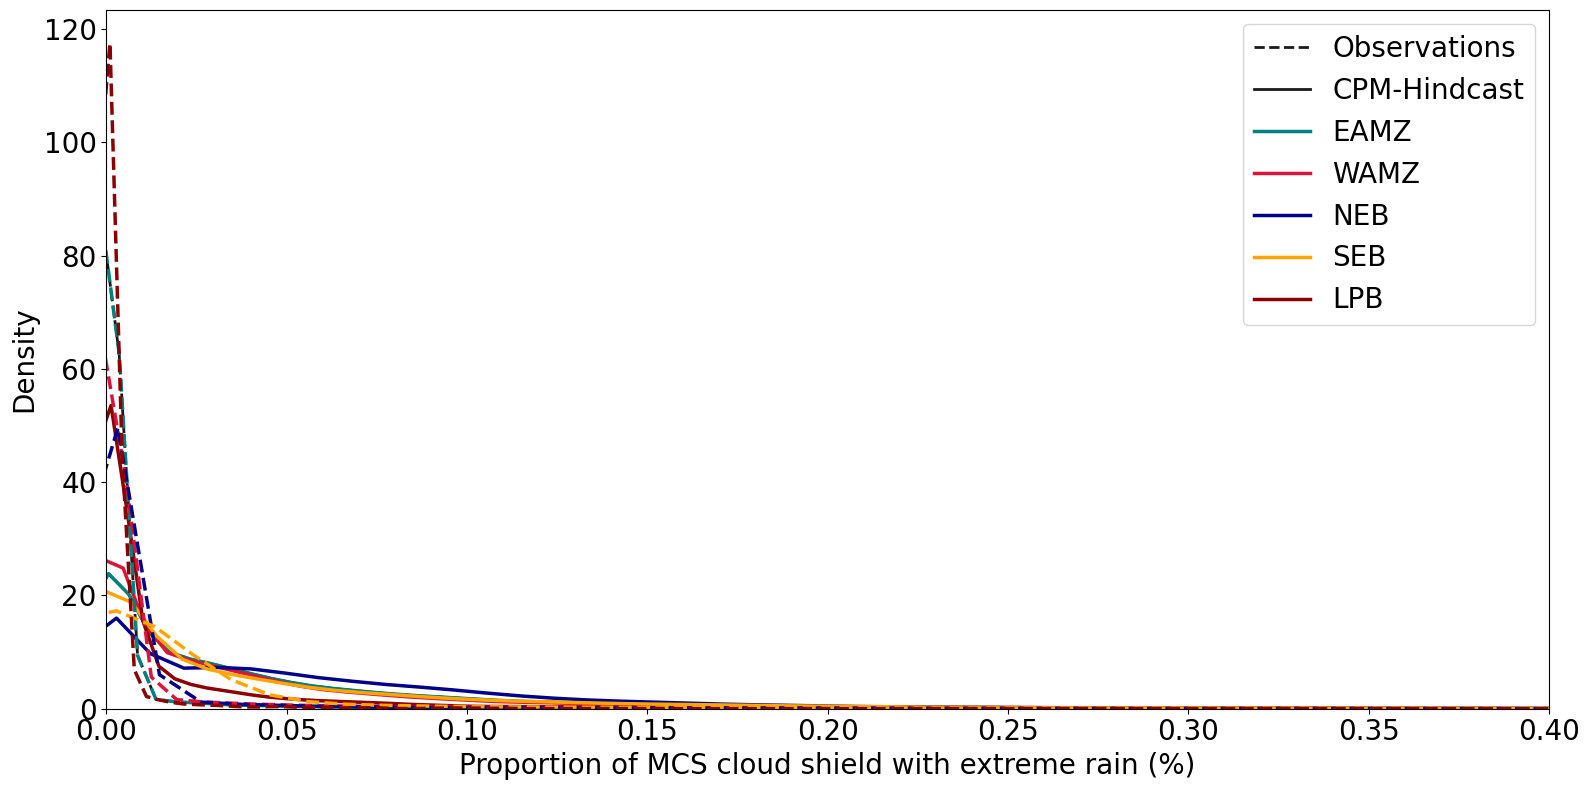

In [228]:
## no. rainy pixels ##
# --------------
import matplotlib
matplotlib.rc_file_defaults()

f = 20

plt.figure(figsize=(16,8))

ax1 = plt.subplot() 

sns.kdeplot(eamz_tracks_obs.extreme_rainy_pixel_proportion,multiple='layer',color='k',label='Observations', linewidth=2, ax=ax1, linestyle='dashed')
sns.kdeplot(eamz_tracks_cpm.extreme_rainy_pixel_proportion,multiple='layer',color='k',label='CPM-Hindcast', linewidth=2, ax=ax1)


sns.kdeplot(eamz_tracks_cpm.extreme_rainy_pixel_proportion,multiple='layer',color='teal',label='EAMZ', linewidth=2.5, ax=ax1)
sns.kdeplot(wamz_tracks_cpm.extreme_rainy_pixel_proportion,multiple='layer',color='crimson',label='WAMZ', linewidth=2.5, ax=ax1)
sns.kdeplot(neb_tracks_cpm.extreme_rainy_pixel_proportion, color='darkblue',multiple='layer',label='NEB', linewidth=2.5, ax=ax1)
sns.kdeplot(seb_tracks_cpm.extreme_rainy_pixel_proportion, color='orange',multiple='layer',label='SEB', linewidth=2.5, ax=ax1)
sns.kdeplot(lpb_tracks_cpm.extreme_rainy_pixel_proportion, color='darkred',multiple='layer',label='LPB', linewidth=2.5, ax=ax1)
ax1.set_ylabel('Density', fontsize=f)
ax1.set_xlabel('Proportion of MCS cloud shield with extreme rain (%)', fontsize=f)
ax1.set_xlim(0,0.4)
plt.legend(loc='best', fontsize=f)
#ax1.set_ylim(0,0.0025)
ax1.set_xticklabels(ax1.get_xticks(), fontsize=f)
ax1.set_yticklabels(ax1.get_yticks(), fontsize=f)

sns.kdeplot(eamz_tracks_obs.extreme_rainy_pixel_proportion,multiple='layer',color='teal',linewidth=2.5, ax=ax1, linestyle='dashed')
sns.kdeplot(wamz_tracks_obs.extreme_rainy_pixel_proportion,multiple='layer',color='crimson',linewidth=2.5, ax=ax1, linestyle='dashed')
sns.kdeplot(neb_tracks_obs.extreme_rainy_pixel_proportion, color='darkblue',multiple='layer',linewidth=2.5, ax=ax1, linestyle='dashed')
sns.kdeplot(seb_tracks_obs.extreme_rainy_pixel_proportion, color='orange',multiple='layer',linewidth=2.5, ax=ax1, linestyle='dashed')
sns.kdeplot(lpb_tracks_obs.extreme_rainy_pixel_proportion, color='darkred',multiple='layer',linewidth=2.5, ax=ax1, linestyle='dashed')

plt.legend(loc='best', fontsize=f)

import matplotlib.ticker
from matplotlib.ticker import StrMethodFormatter
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))

plt.tight_layout()

**Colocated pixels**

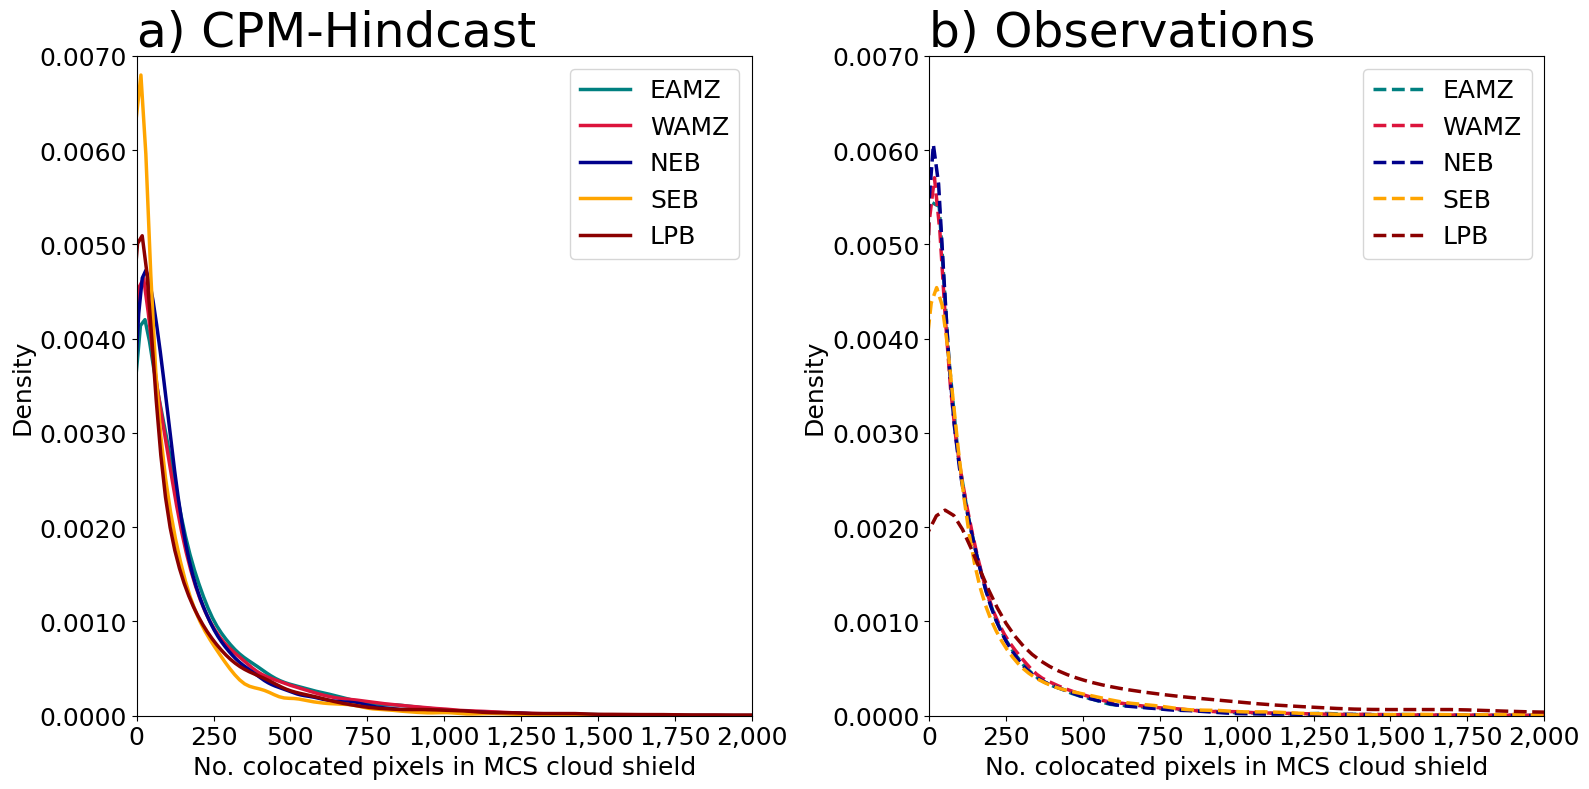

In [179]:
### colocated pixels ###
# --------------
import matplotlib
matplotlib.rc_file_defaults()

f = 18

plt.figure(figsize=(16,8))

ax1 = plt.subplot(1, 2, 1) 
ax1.set_title('a) CPM-Hindcast ', loc='left', fontsize= 35)

sns.kdeplot(eamz_tracks_cpm.colocated_pixels,multiple='layer',color='teal',label='EAMZ', linewidth=2.5, ax=ax1)
sns.kdeplot(wamz_tracks_cpm.colocated_pixels,multiple='layer',color='crimson',label='WAMZ', linewidth=2.5, ax=ax1)
sns.kdeplot(neb_tracks_cpm.colocated_pixels, color='darkblue',multiple='layer',label='NEB', linewidth=2.5, ax=ax1)
sns.kdeplot(seb_tracks_cpm.colocated_pixels, color='orange',multiple='layer',label='SEB', linewidth=2.5, ax=ax1)
sns.kdeplot(lpb_tracks_cpm.colocated_pixels, color='darkred',multiple='layer',label='LPB', linewidth=2.5, ax=ax1)
ax1.set_ylabel('Density', fontsize=f)
ax1.set_xlabel('No. colocated pixels in MCS cloud shield', fontsize=f)
plt.legend(loc='best', fontsize=f)
ax1.set_xlim(0,2000)
ax1.set_ylim(0,0.007)
ax1.set_xticklabels(ax1.get_xticks(), fontsize=f)
ax1.set_yticklabels(ax1.get_yticks(), fontsize=f)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.4f}')) # No decimal places
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) # No decimal places

#ax1.set_xscale('symlog')



ax2 = plt.subplot(1, 2, 2) 
ax2.set_title('b) Observations ', loc='left', fontsize= 35)

sns.kdeplot(eamz_tracks_obs.colocated_pixels,multiple='layer',color='teal',label='EAMZ', linewidth=2.5, ax=ax2, linestyle='dashed')
sns.kdeplot(wamz_tracks_obs.colocated_pixels,multiple='layer',color='crimson',label='WAMZ', linewidth=2.5, ax=ax2, linestyle='dashed')
sns.kdeplot(neb_tracks_obs.colocated_pixels, color='darkblue',multiple='layer',label='NEB', linewidth=2.5, ax=ax2, linestyle='dashed')
sns.kdeplot(seb_tracks_obs.colocated_pixels, color='orange',multiple='layer',label='SEB', linewidth=2.5, ax=ax2, linestyle='dashed')
sns.kdeplot(lpb_tracks_obs.colocated_pixels, color='darkred',multiple='layer',label='LPB', linewidth=2.5, ax=ax2, linestyle='dashed')
ax2.set_ylabel('Density', fontsize=f)
ax2.set_xlabel('No. colocated pixels in MCS cloud shield', fontsize=f)
ax2.set_ylim(0,0.007)
ax2.set_xlim(0, 2000)
ax2.set_xticklabels(ax2.get_xticks(), fontsize=f)
ax2.set_yticklabels(ax2.get_yticks(), fontsize=f)

plt.legend(loc='best', fontsize=f)

import matplotlib.ticker
from matplotlib.ticker import StrMethodFormatter
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.4f}')) # No decimal places
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) # No decimal places


plt.tight_layout()

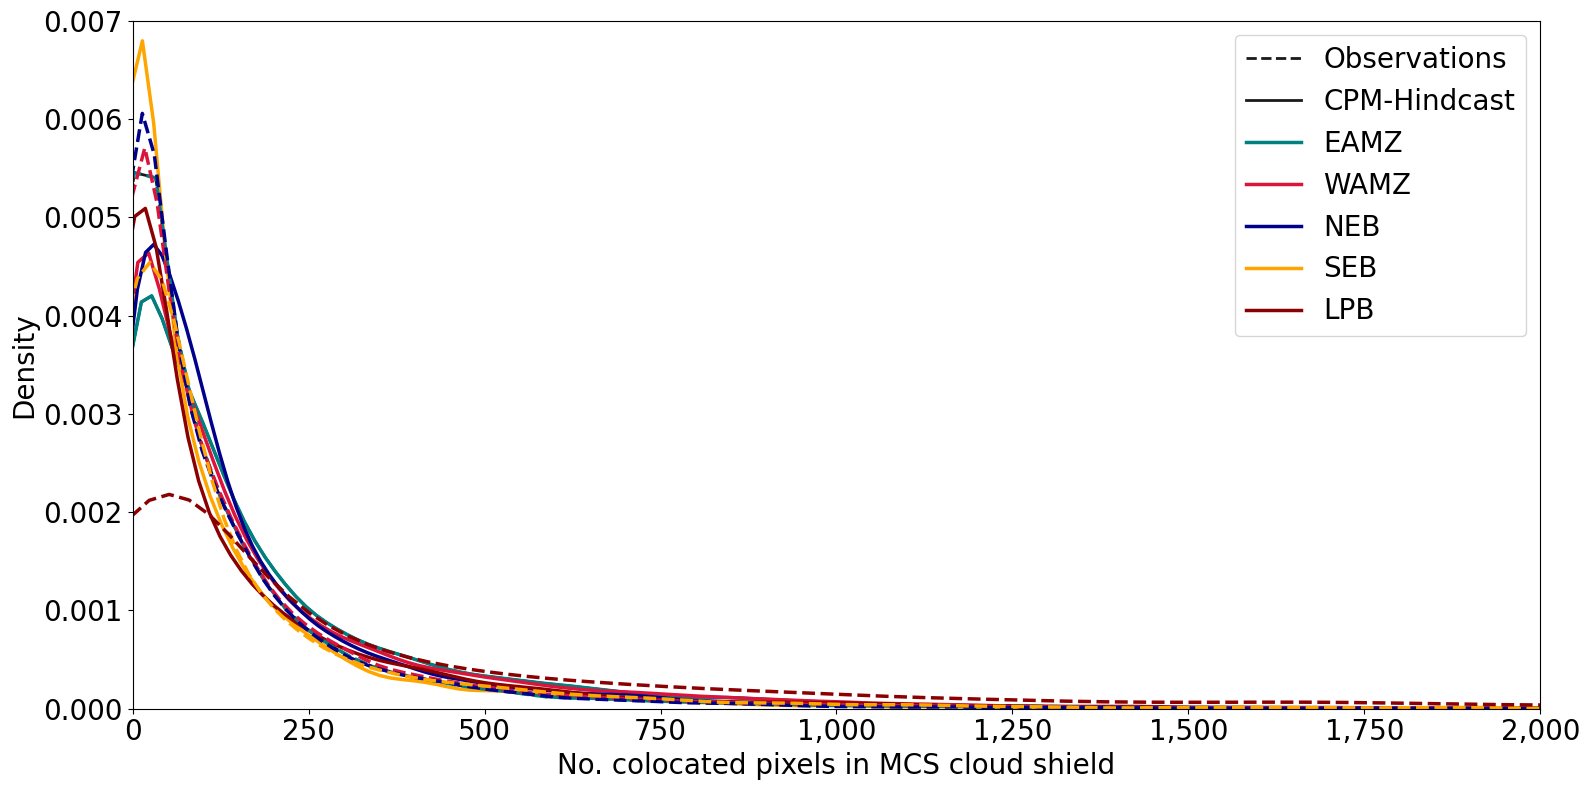

In [177]:
## mean precip ##
# --------------
import matplotlib
matplotlib.rc_file_defaults()

f = 20

plt.figure(figsize=(16,8))

ax1 = plt.subplot() 

sns.kdeplot(eamz_tracks_obs.colocated_pixels,multiple='layer',color='k',label='Observations', linewidth=2, ax=ax1, linestyle='dashed')
sns.kdeplot(eamz_tracks_cpm.colocated_pixels,multiple='layer',color='k',label='CPM-Hindcast', linewidth=2, ax=ax1)


sns.kdeplot(eamz_tracks_cpm.colocated_pixels,multiple='layer',color='teal',label='EAMZ', linewidth=2.5, ax=ax1)
sns.kdeplot(wamz_tracks_cpm.colocated_pixels,multiple='layer',color='crimson',label='WAMZ', linewidth=2.5, ax=ax1)
sns.kdeplot(neb_tracks_cpm.colocated_pixels, color='darkblue',multiple='layer',label='NEB', linewidth=2.5, ax=ax1)
sns.kdeplot(seb_tracks_cpm.colocated_pixels, color='orange',multiple='layer',label='SEB', linewidth=2.5, ax=ax1)
sns.kdeplot(lpb_tracks_cpm.colocated_pixels, color='darkred',multiple='layer',label='LPB', linewidth=2.5, ax=ax1)
ax1.set_ylabel('Density', fontsize=f)
ax1.set_xlabel('No. colocated pixels in MCS cloud shield', fontsize=f)
ax1.set_xlim(0,2000)
plt.legend(loc='best', fontsize=f)
ax1.set_ylim(0,0.007)
ax1.set_xticklabels(ax1.get_xticks(), fontsize=f)
ax1.set_yticklabels(ax1.get_yticks(), fontsize=f)

sns.kdeplot(eamz_tracks_obs.colocated_pixels,multiple='layer',color='teal',linewidth=2.5, ax=ax1, linestyle='dashed')
sns.kdeplot(wamz_tracks_obs.colocated_pixels,multiple='layer',color='crimson',linewidth=2.5, ax=ax1, linestyle='dashed')
sns.kdeplot(neb_tracks_obs.colocated_pixels, color='darkblue',multiple='layer',linewidth=2.5, ax=ax1, linestyle='dashed')
sns.kdeplot(seb_tracks_obs.colocated_pixels, color='orange',multiple='layer',linewidth=2.5, ax=ax1, linestyle='dashed')
sns.kdeplot(lpb_tracks_obs.colocated_pixels, color='darkred',multiple='layer',linewidth=2.5, ax=ax1, linestyle='dashed')

plt.legend(loc='best', fontsize=f)

import matplotlib.ticker
from matplotlib.ticker import StrMethodFormatter
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}'))
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))


plt.tight_layout()

**Proportion of cloud shield with colocated pixels**

In [229]:
i = 0
dataframes = [eamz_tracks_cpm, wamz_tracks_cpm, neb_tracks_cpm, seb_tracks_cpm, lpb_tracks_cpm, eamz_tracks_obs, wamz_tracks_obs, neb_tracks_obs, seb_tracks_obs, lpb_tracks_obs]

for file in dataframes:
    file['colocated_pixel_proportion'] = (file['colocated_pixels'] / file['num'])*100

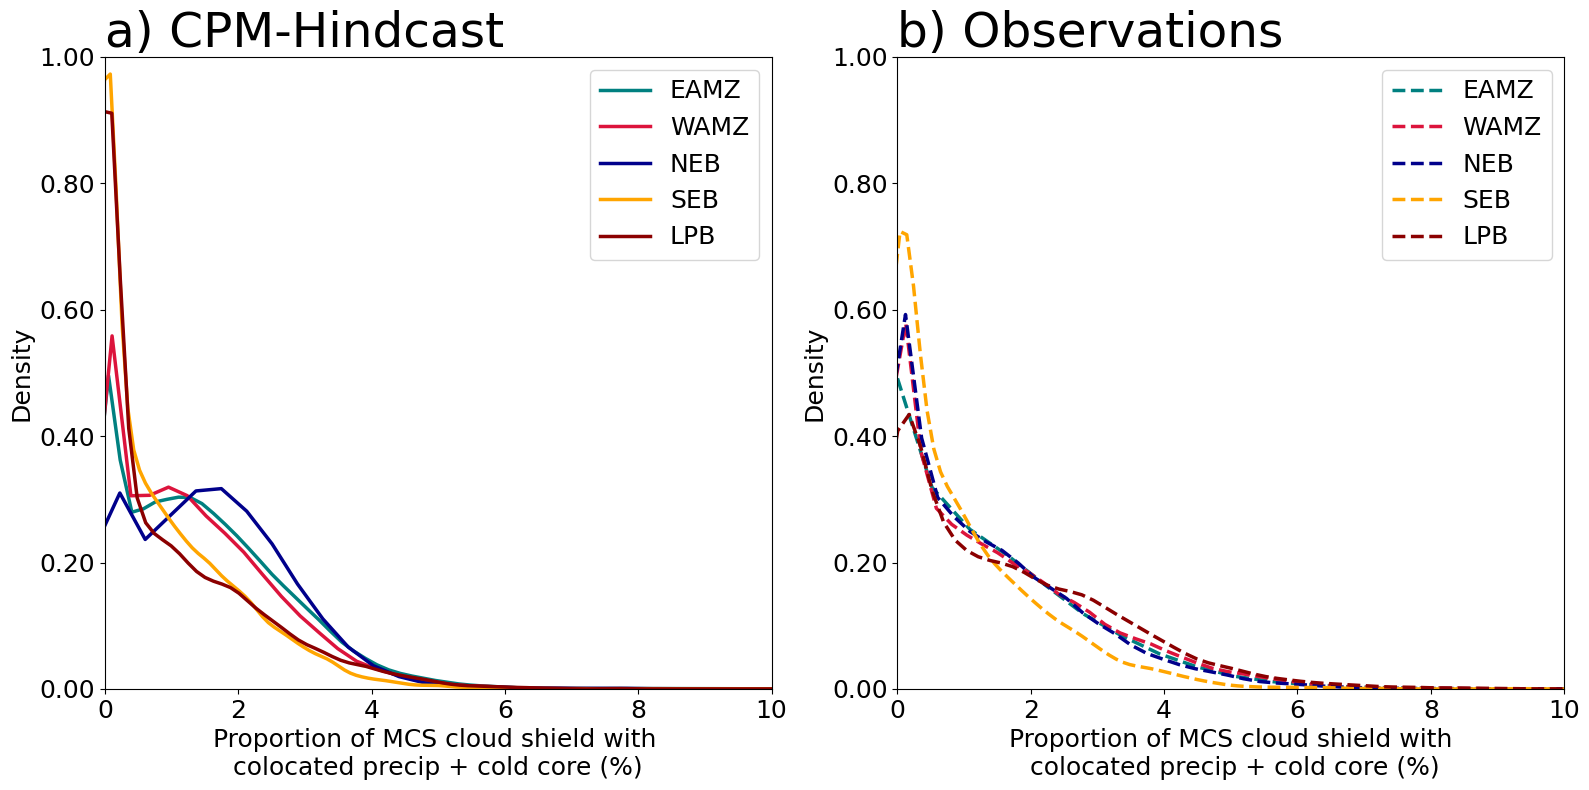

In [236]:
### proportion of cloud shield with rain ###
# --------------
import matplotlib
matplotlib.rc_file_defaults()

f = 18

plt.figure(figsize=(16,8))

ax1 = plt.subplot(1, 2, 1) 
ax1.set_title('a) CPM-Hindcast ', loc='left', fontsize= 35)

sns.kdeplot(eamz_tracks_cpm.colocated_pixel_proportion,multiple='layer',color='teal',label='EAMZ', linewidth=2.5, ax=ax1)
sns.kdeplot(wamz_tracks_cpm.colocated_pixel_proportion,multiple='layer',color='crimson',label='WAMZ', linewidth=2.5, ax=ax1)
sns.kdeplot(neb_tracks_cpm.colocated_pixel_proportion, color='darkblue',multiple='layer',label='NEB', linewidth=2.5, ax=ax1)
sns.kdeplot(seb_tracks_cpm.colocated_pixel_proportion, color='orange',multiple='layer',label='SEB', linewidth=2.5, ax=ax1)
sns.kdeplot(lpb_tracks_cpm.colocated_pixel_proportion, color='darkred',multiple='layer',label='LPB', linewidth=2.5, ax=ax1)
ax1.set_ylabel('Density', fontsize=f)
ax1.set_xlabel('Proportion of MCS cloud shield with \ncolocated precip + cold core (%)', fontsize=f)
plt.legend(loc='best', fontsize=f)
ax1.set_xlim(0,10)
ax1.set_ylim(0,1)
ax1.set_xticklabels(ax1.get_xticks(), fontsize=f)
ax1.set_yticklabels(ax1.get_yticks(), fontsize=f)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) # No decimal places
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) # No decimal places

#ax1.set_xscale('symlog')



ax2 = plt.subplot(1, 2, 2) 
ax2.set_title('b) Observations ', loc='left', fontsize= 35)

sns.kdeplot(eamz_tracks_obs.colocated_pixel_proportion,multiple='layer',color='teal',label='EAMZ', linewidth=2.5, ax=ax2, linestyle='dashed')
sns.kdeplot(wamz_tracks_obs.colocated_pixel_proportion,multiple='layer',color='crimson',label='WAMZ', linewidth=2.5, ax=ax2, linestyle='dashed')
sns.kdeplot(neb_tracks_obs.colocated_pixel_proportion, color='darkblue',multiple='layer',label='NEB', linewidth=2.5, ax=ax2, linestyle='dashed')
sns.kdeplot(seb_tracks_obs.colocated_pixel_proportion, color='orange',multiple='layer',label='SEB', linewidth=2.5, ax=ax2, linestyle='dashed')
sns.kdeplot(lpb_tracks_obs.colocated_pixel_proportion, color='darkred',multiple='layer',label='LPB', linewidth=2.5, ax=ax2, linestyle='dashed')
ax2.set_ylabel('Density', fontsize=f)
ax2.set_xlabel('Proportion of MCS cloud shield with\n colocated precip + cold core (%)', fontsize=f)
ax2.set_ylim(0,1)
ax2.set_xlim(0, 10)
ax2.set_xticklabels(ax2.get_xticks(), fontsize=f)
ax2.set_yticklabels(ax2.get_yticks(), fontsize=f)

plt.legend(loc='best', fontsize=f)

import matplotlib.ticker
from matplotlib.ticker import StrMethodFormatter
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) # No decimal places
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) # No decimal places


plt.tight_layout()

## Locations of max precip... ##

**Whole domain first, then by regional box**

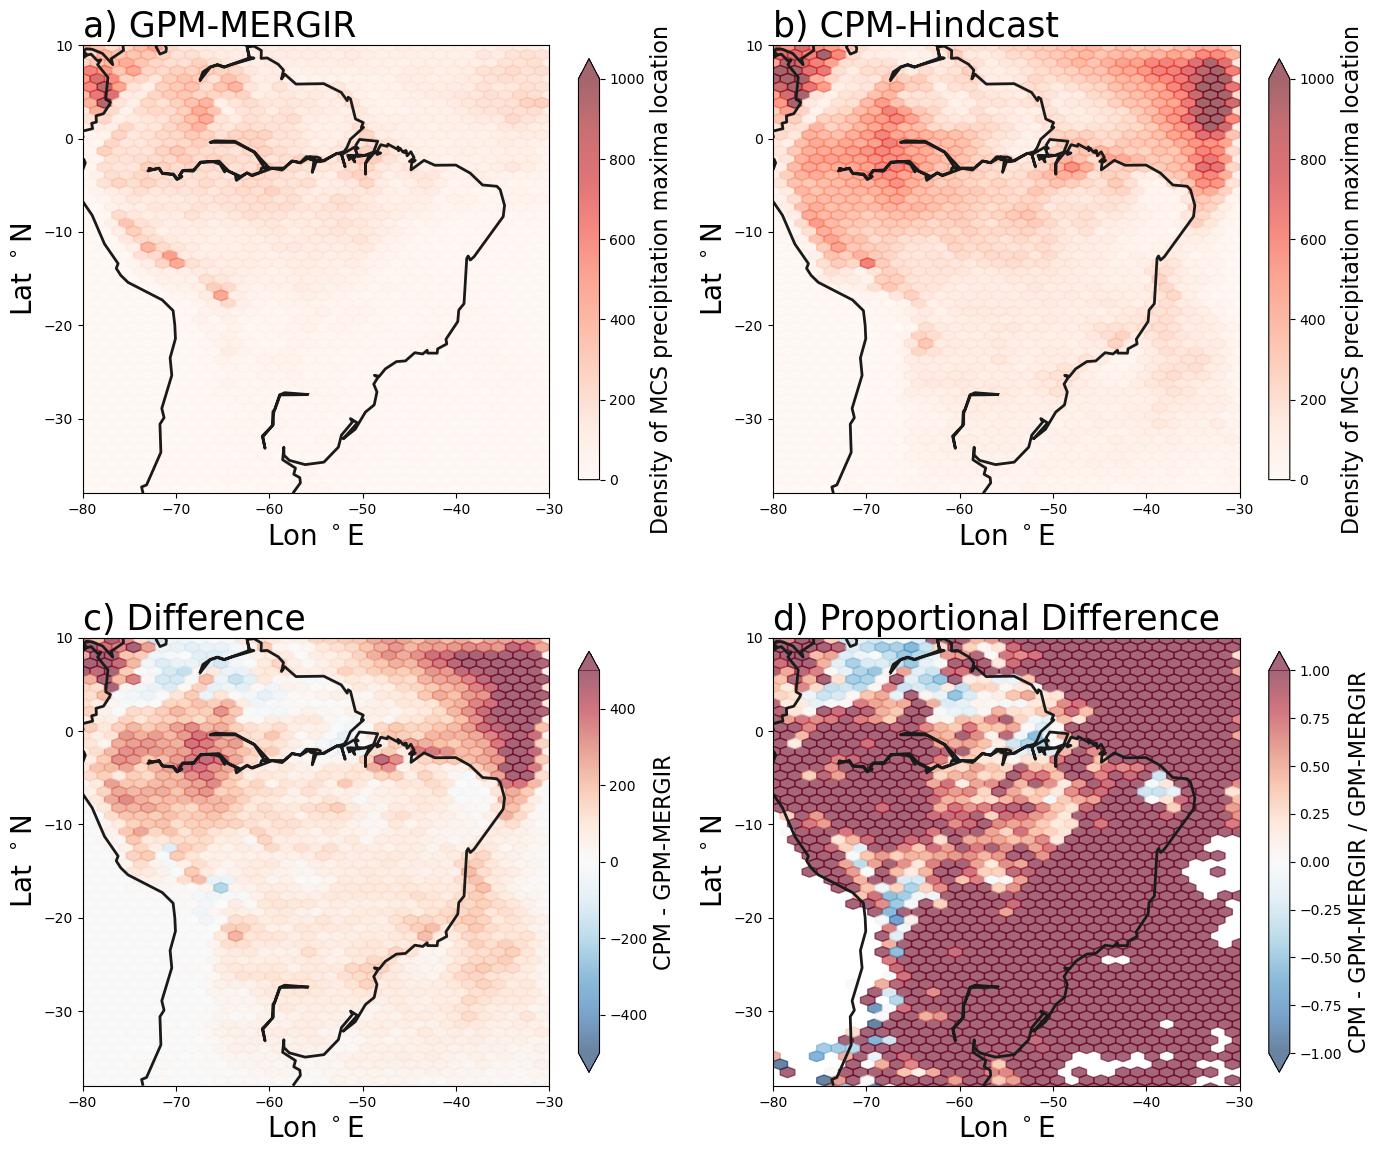

In [191]:
import mpl_toolkits
from mpl_toolkits.basemap import Basemap

x_f = all_years_cpm.max_precip_lon
y_f = all_years_cpm.max_precip_lat

x_o = all_years_obs.max_precip_lon
y_o = all_years_obs.max_precip_lat


fig = plt.figure(figsize=(14,12))

ax1=plt.subplot(2,2,1)
m = Basemap(llcrnrlon=-80, llcrnrlat=-38,urcrnrlon=-30, urcrnrlat=10) # create Basemap object
m.drawcoastlines(linewidth=2) # draw coastlines
#m.drawcountries() # draw political boundaries
#m.shadedrelief()

hx_o = m.hexbin(x_o, y_o, gridsize=(32,32),cmap='Reds',alpha=0.6, vmin=0,vmax=1000, extent=(-80, -30, -40, 15))
cbar = plt.colorbar(hx_o, ax=ax1, shrink=0.8, extend='max')
cbar.set_label(label='Density of MCS precipitation maxima location', fontsize=16)
ax1.set_xlabel('Lon $^\circ$E', fontsize=20)
ax1.set_ylabel('Lat $^\circ$N', fontsize=20)
ax1.set_xticks([-80,-70,-60,-50,-40,-30],fontsize=20)
ax1.set_yticks([-30,-20,-10,0,10],fontsize=20)
ax1.grid(False)
ax1.set_title('a) GPM-MERGIR', loc='left',fontsize=25)


ax2=plt.subplot(2,2,2)
m = Basemap(llcrnrlon=-80, llcrnrlat=-38,urcrnrlon=-30, urcrnrlat=10) # create Basemap object
m.drawcoastlines(linewidth=2) # draw coastlines
#m.drawcountries() # draw political boundaries
#m.shadedrelief()
hx_f = m.hexbin(x_f, y_f, gridsize=(32,32),cmap='Reds',alpha=0.6, vmin=0,vmax=1000, extent=(-80, -30, -40, 15))
cbar = plt.colorbar(hx_f, ax=ax2, shrink=0.8, extend='max')
cbar.set_label(label='Density of MCS precipitation maxima location', fontsize=16)
ax2.set_xlabel('Lon $^\circ$E', fontsize=20)
ax2.set_ylabel('Lat $^\circ$N', fontsize=20)
ax2.set_xticks([-80,-70,-60,-50,-40,-30],fontsize=20)
ax2.set_yticks([-30,-20,-10,0,10],fontsize=20)
ax2.grid(False)
ax2.set_title('b) CPM-Hindcast', loc='left',fontsize=25)


ax3=plt.subplot(2,2,3)
m = Basemap(llcrnrlon=-80, llcrnrlat=-38,urcrnrlon=-30, urcrnrlat=10) # create Basemap object
m.drawcoastlines(linewidth=2) # draw coastlines
#m.drawcountries() # draw political boundaries
#m.shadedrelief()

# Create dummy hexbin using whatever data..:
hx_diff=m.hexbin(x_f, y_f, gridsize=(32,32), cmap='RdBu_r',alpha=0.6, vmin=-500,vmax=500, extent=(-80, -30, -40, 15))
hx_diff.set_array(hx_f.get_array()-hx_o.get_array())
cbar = plt.colorbar(hx_diff, ax=ax3, shrink=0.8, extend='both')
cbar.set_label(label='CPM - GPM-MERGIR', fontsize=16)
#cbar.ax.tick_params(labelsize=12)
ax3.set_xlabel('Lon $^\circ$E', fontsize=20)
ax3.set_ylabel('Lat $^\circ$N', fontsize=20)
ax3.set_xticks([-80,-70,-60,-50,-40,-30],fontsize=20)
ax3.set_yticks([-30,-20,-10,0,10],fontsize=20)
ax3.grid(False)
ax3.set_title('c) Difference', loc='left',fontsize=25)


ax4=plt.subplot(2,2,4)
m = Basemap(llcrnrlon=-80, llcrnrlat=-38,urcrnrlon=-30, urcrnrlat=10) # create Basemap object
m.drawcoastlines(linewidth=2) # draw coastlines
#m.drawcountries() # draw political boundaries
#m.shadedrelief()

# Create dummy hexbin using whatever data..:
hx_diff=m.hexbin(x_f, y_f, gridsize=(32,32), cmap='RdBu_r',alpha=0.6, vmin=-1,vmax=1, extent=(-80, -30, -40, 15))
hx_diff.set_array((hx_f.get_array()-hx_o.get_array())/hx_o.get_array())
cbar = plt.colorbar(hx_diff, ax=ax4, shrink=0.8, extend='both')
cbar.set_label(label='CPM - GPM-MERGIR / GPM-MERGIR', fontsize=16)
#cbar.ax.tick_params(labelsize=12)
ax4.set_xlabel('Lon $^\circ$E', fontsize=20)
ax4.set_ylabel('Lat $^\circ$N', fontsize=20)
ax4.set_xticks([-80,-70,-60,-50,-40,-30],fontsize=20)
ax4.set_yticks([-30,-20,-10,0,10],fontsize=20)
ax4.grid(False)
ax4.set_title('d) Proportional Difference', loc='left',fontsize=25)

#fig.text(0.25,0.75,'MCS frequency in unfiltered tracks datasets (2001-2007)', fontsize=30)

plt.tight_layout()

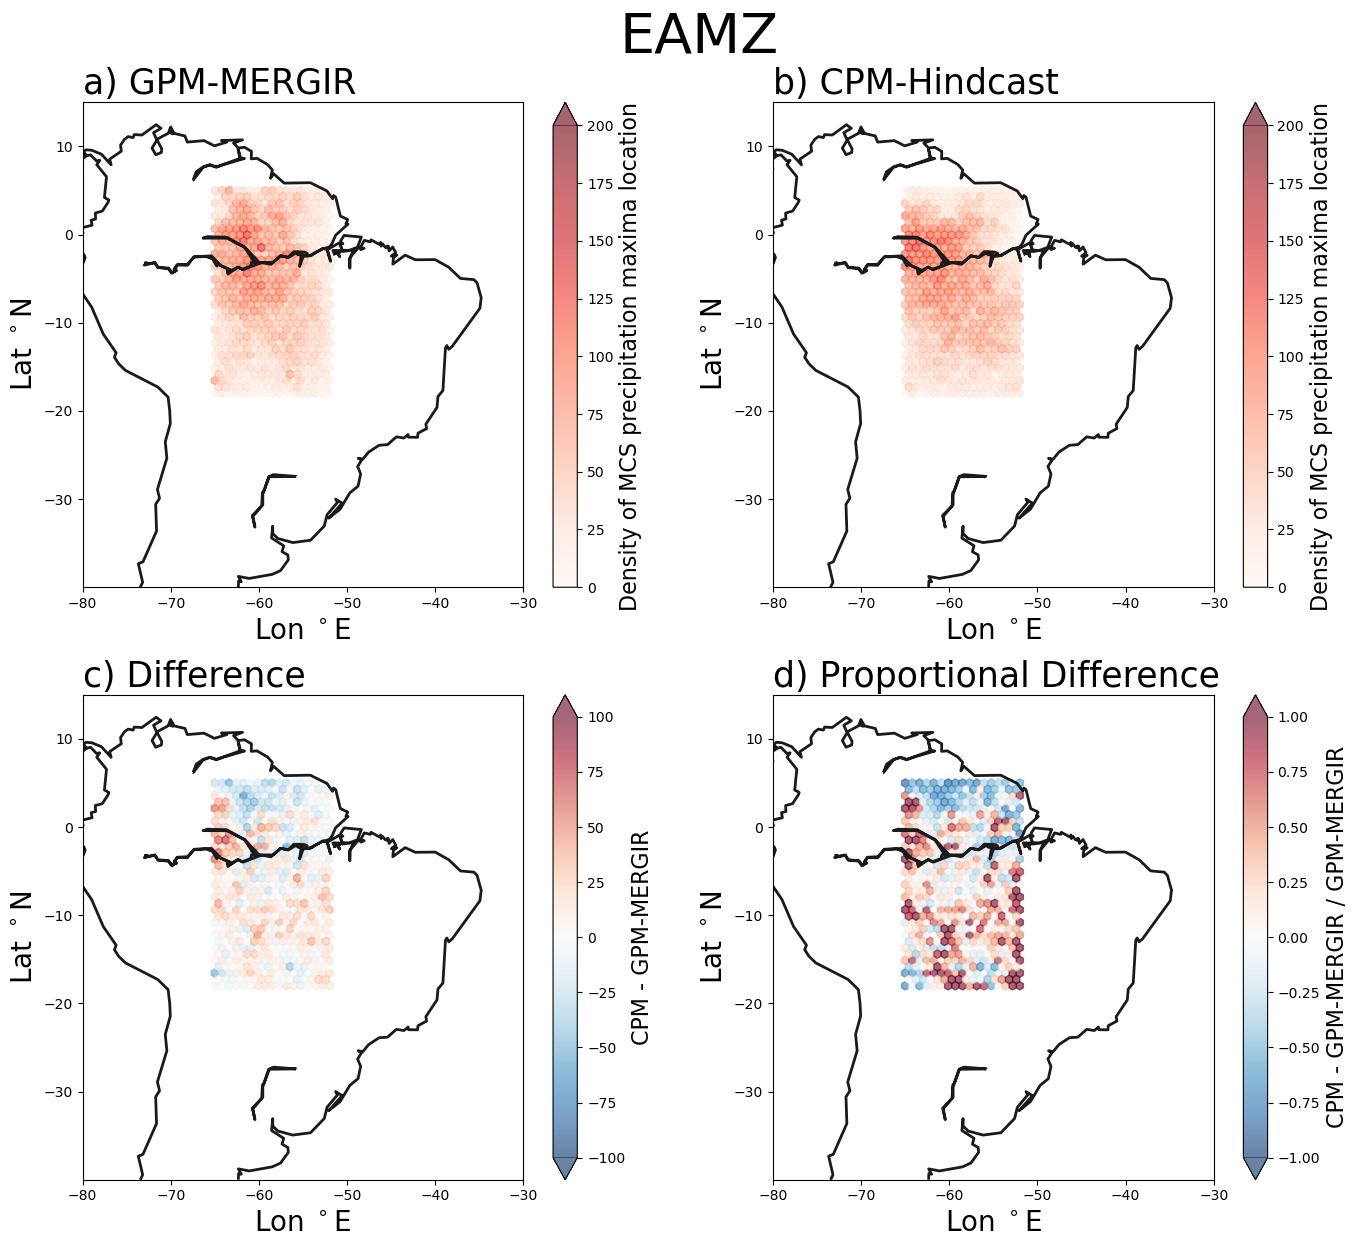

In [291]:
import mpl_toolkits
from mpl_toolkits.basemap import Basemap
import matplotlib.patches as mpatches
from matplotlib.patches import Polygon


x_f = eamz_tracks_cpm.max_precip_lon
y_f = eamz_tracks_cpm.max_precip_lat

x_o = eamz_tracks_obs.max_precip_lon
y_o = eamz_tracks_obs.max_precip_lat

### Eastern Amazon (65-52^W, 18-5^S) ###


fig = plt.figure(figsize=(14,12))

ax1=plt.subplot(2,2,1)
m = Basemap(llcrnrlon=-80, llcrnrlat=-40,urcrnrlon=-30, urcrnrlat=15) # create Basemap object
m.drawcoastlines(linewidth=2) # draw coastlines
#m.drawcountries() # draw political boundaries
#m.shadedrelief()
hx_o = m.hexbin(x_o, y_o, gridsize=(16,16),cmap='Reds',alpha=0.6, vmin=0,vmax=200, extent=(-65, -52, -18, 5))
cbar = plt.colorbar(hx_o, ax=ax1, shrink=1, extend='max')
cbar.set_label(label='Density of MCS precipitation maxima location', fontsize=16)
ax1.set_xlabel('Lon $^\circ$E', fontsize=20)
ax1.set_ylabel('Lat $^\circ$N', fontsize=20)
ax1.set_xticks([-80,-70,-60,-50,-40,-30],fontsize=20)
ax1.set_yticks([-30,-20,-10,0,10],fontsize=20)
ax1.grid(False)
ax1.set_title('a) GPM-MERGIR', loc='left',fontsize=25)


ax2=plt.subplot(2,2,2)
m = Basemap(llcrnrlon=-80, llcrnrlat=-40,urcrnrlon=-30, urcrnrlat=15) # create Basemap object
m.drawcoastlines(linewidth=2) # draw coastlines
#m.drawcountries() # draw political boundaries
#m.shadedrelief()
hx_f = m.hexbin(x_f, y_f, gridsize=(16,16),cmap='Reds',alpha=0.6, vmin=0,vmax=200, extent=(-65, -52, -18, 5))
cbar = plt.colorbar(hx_f, ax=ax2, shrink=1, extend='max')
cbar.set_label(label='Density of MCS precipitation maxima location', fontsize=16)
ax2.set_xlabel('Lon $^\circ$E', fontsize=20)
ax2.set_ylabel('Lat $^\circ$N', fontsize=20)
ax2.set_xticks([-80,-70,-60,-50,-40,-30],fontsize=20)
ax2.set_yticks([-30,-20,-10,0,10],fontsize=20)
ax2.grid(False)
ax2.set_title('b) CPM-Hindcast', loc='left',fontsize=25)


ax3=plt.subplot(2,2,3)
m = Basemap(llcrnrlon=-80, llcrnrlat=-40,urcrnrlon=-30, urcrnrlat=15) # create Basemap object
m.drawcoastlines(linewidth=2) # draw coastlines
#m.drawcountries() # draw political boundaries
#m.shadedrelief()

# Create dummy hexbin using whatever data..:
hx_diff=m.hexbin(x_f, y_f, gridsize=(16,16),cmap='RdBu_r',alpha=0.6, vmin=-100,vmax=100, extent=(-65, -52, -18, 5))
hx_diff.set_array(hx_f.get_array()-hx_o.get_array())
cbar = plt.colorbar(hx_diff, ax=ax3, shrink=1, extend='both')
cbar.set_label(label='CPM - GPM-MERGIR', fontsize=16)
#cbar.ax.tick_params(labelsize=12)
ax3.set_xlabel('Lon $^\circ$E', fontsize=20)
ax3.set_ylabel('Lat $^\circ$N', fontsize=20)
ax3.set_xticks([-80,-70,-60,-50,-40,-30],fontsize=20)
ax3.set_yticks([-30,-20,-10,0,10],fontsize=20)
ax3.grid(False)
ax3.set_title('c) Difference', loc='left',fontsize=25)


ax4=plt.subplot(2,2,4)
m = Basemap(llcrnrlon=-80, llcrnrlat=-40,urcrnrlon=-30, urcrnrlat=15) # create Basemap object
m.drawcoastlines(linewidth=2) # draw coastlines
#m.drawcountries() # draw political boundaries
#m.shadedrelief()

# Create dummy hexbin using whatever data..:
hx_diff=m.hexbin(x_f, y_f, gridsize=(16,16),cmap='RdBu_r',alpha=0.6, vmin=-1,vmax=1, extent=(-65, -52, -18, 5))
hx_diff.set_array((hx_f.get_array()-hx_o.get_array())/hx_o.get_array())
cbar = plt.colorbar(hx_diff, ax=ax4, shrink=1, extend='both')
cbar.set_label(label='CPM - GPM-MERGIR / GPM-MERGIR', fontsize=16)
#cbar.ax.tick_params(labelsize=12)
ax4.set_xlabel('Lon $^\circ$E', fontsize=20)
ax4.set_ylabel('Lat $^\circ$N', fontsize=20)
ax4.set_xticks([-80,-70,-60,-50,-40,-30],fontsize=20)
ax4.set_yticks([-30,-20,-10,0,10],fontsize=20)
ax4.grid(False)
ax4.set_title('d) Proportional Difference', loc='left',fontsize=25)

fig.text(0.46,1,'EAMZ', fontsize=40)

plt.tight_layout()

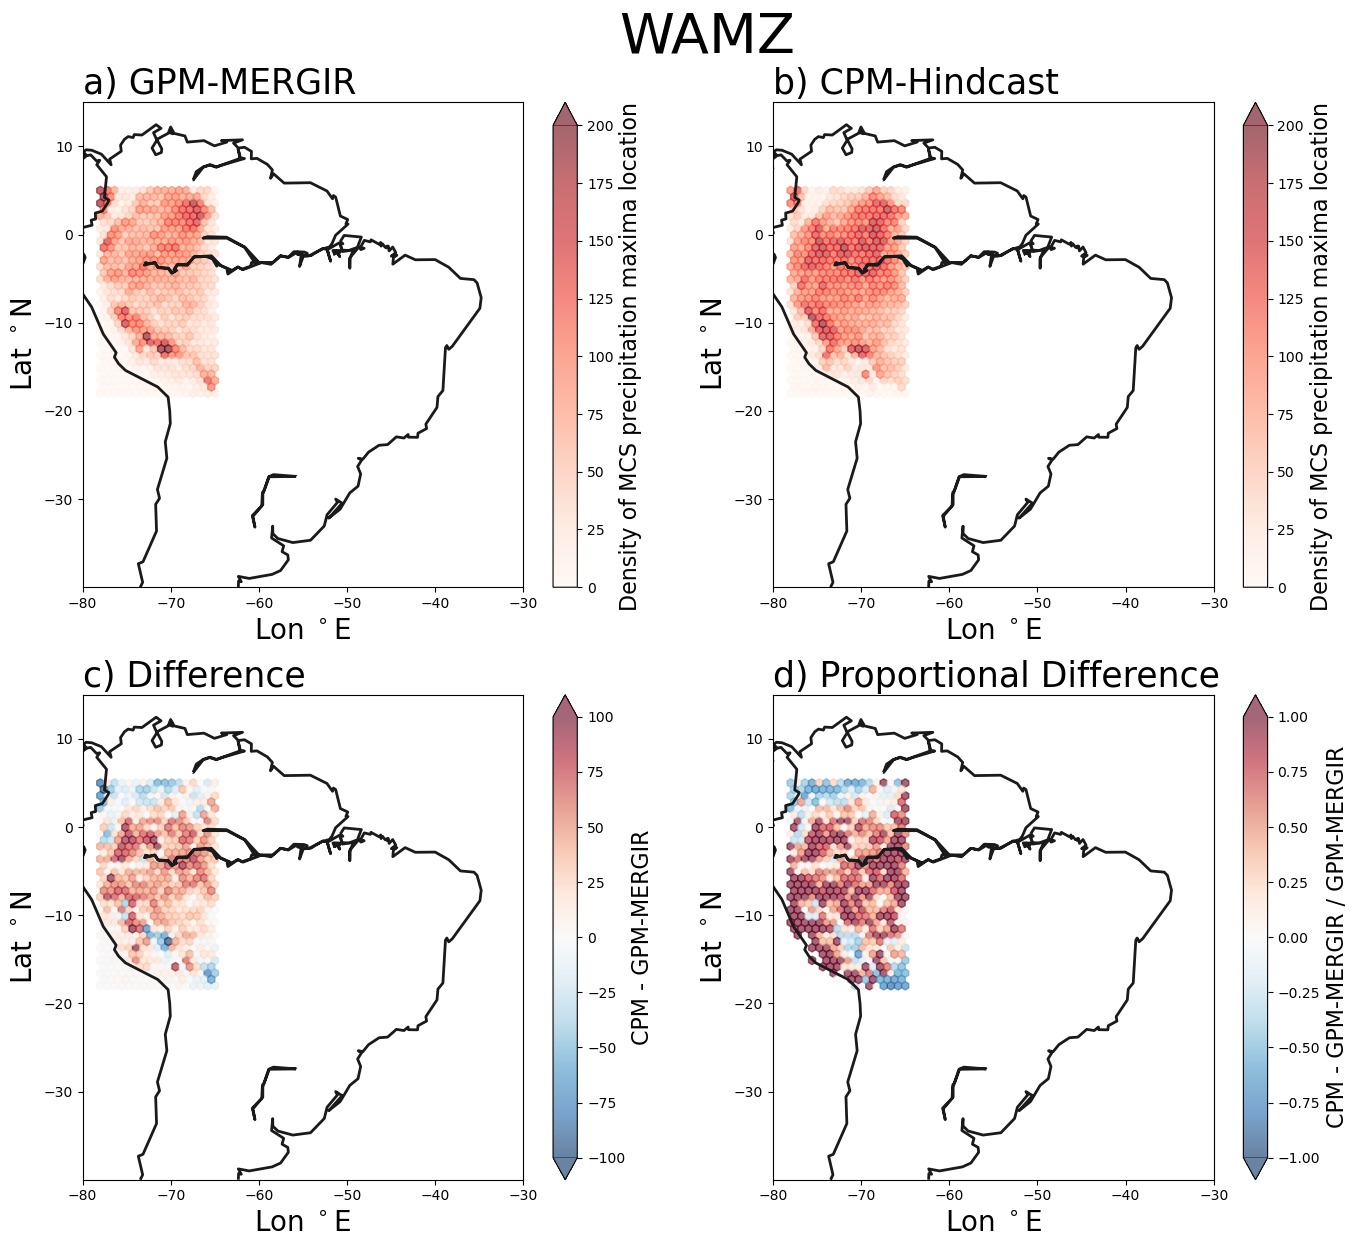

In [284]:
import mpl_toolkits
from mpl_toolkits.basemap import Basemap
import matplotlib.patches as mpatches
from matplotlib.patches import Polygon


x_f = wamz_tracks_cpm.max_precip_lon
y_f = wamz_tracks_cpm.max_precip_lat

x_o = wamz_tracks_obs.max_precip_lon
y_o = wamz_tracks_obs.max_precip_lat

### Western Amazon (78-65^W, 18-5^S) ###


fig = plt.figure(figsize=(14,12))

ax1=plt.subplot(2,2,1)
m = Basemap(llcrnrlon=-80, llcrnrlat=-40,urcrnrlon=-30, urcrnrlat=15) # create Basemap object
m.drawcoastlines(linewidth=2) # draw coastlines
#m.drawcountries() # draw political boundaries
#m.shadedrelief()
hx_o = m.hexbin(x_o, y_o, gridsize=(16,16),cmap='Reds',alpha=0.6, vmin=0,vmax=200, extent=(-78, -65, -18, 5))
cbar = plt.colorbar(hx_o, ax=ax1, shrink=1, extend='max')
cbar.set_label(label='Density of MCS precipitation maxima location', fontsize=16)
ax1.set_xlabel('Lon $^\circ$E', fontsize=20)
ax1.set_ylabel('Lat $^\circ$N', fontsize=20)
ax1.set_xticks([-80,-70,-60,-50,-40,-30],fontsize=20)
ax1.set_yticks([-30,-20,-10,0,10],fontsize=20)
ax1.grid(False)
ax1.set_title('a) GPM-MERGIR', loc='left',fontsize=25)


ax2=plt.subplot(2,2,2)
m = Basemap(llcrnrlon=-80, llcrnrlat=-40,urcrnrlon=-30, urcrnrlat=15) # create Basemap object
m.drawcoastlines(linewidth=2) # draw coastlines
#m.drawcountries() # draw political boundaries
#m.shadedrelief()
hx_f = m.hexbin(x_f, y_f, gridsize=(16,16),cmap='Reds',alpha=0.6, vmin=0,vmax=200, extent=(-78, -65, -18, 5))
cbar = plt.colorbar(hx_f, ax=ax2, shrink=1, extend='max')
cbar.set_label(label='Density of MCS precipitation maxima location', fontsize=16)
ax2.set_xlabel('Lon $^\circ$E', fontsize=20)
ax2.set_ylabel('Lat $^\circ$N', fontsize=20)
ax2.set_xticks([-80,-70,-60,-50,-40,-30],fontsize=20)
ax2.set_yticks([-30,-20,-10,0,10],fontsize=20)
ax2.grid(False)
ax2.set_title('b) CPM-Hindcast', loc='left',fontsize=25)


ax3=plt.subplot(2,2,3)
m = Basemap(llcrnrlon=-80, llcrnrlat=-40,urcrnrlon=-30, urcrnrlat=15) # create Basemap object
m.drawcoastlines(linewidth=2) # draw coastlines
#m.drawcountries() # draw political boundaries
#m.shadedrelief()

# Create dummy hexbin using whatever data..:
hx_diff=m.hexbin(x_f, y_f, gridsize=(16,16),cmap='RdBu_r',alpha=0.6, vmin=-100,vmax=100, extent=(-78, -65, -18, 5))
hx_diff.set_array(hx_f.get_array()-hx_o.get_array())
cbar = plt.colorbar(hx_diff, ax=ax3, shrink=1, extend='both')
cbar.set_label(label='CPM - GPM-MERGIR', fontsize=16)
#cbar.ax.tick_params(labelsize=12)
ax3.set_xlabel('Lon $^\circ$E', fontsize=20)
ax3.set_ylabel('Lat $^\circ$N', fontsize=20)
ax3.set_xticks([-80,-70,-60,-50,-40,-30],fontsize=20)
ax3.set_yticks([-30,-20,-10,0,10],fontsize=20)
ax3.grid(False)
ax3.set_title('c) Difference', loc='left',fontsize=25)


ax4=plt.subplot(2,2,4)
m = Basemap(llcrnrlon=-80, llcrnrlat=-40,urcrnrlon=-30, urcrnrlat=15) # create Basemap object
m.drawcoastlines(linewidth=2) # draw coastlines
#m.drawcountries() # draw political boundaries
#m.shadedrelief()

# Create dummy hexbin using whatever data..:
hx_diff=m.hexbin(x_f, y_f, gridsize=(16,16),cmap='RdBu_r',alpha=0.6, vmin=-1,vmax=1, extent=(-78, -65, -18, 5))
hx_diff.set_array((hx_f.get_array()-hx_o.get_array())/hx_o.get_array())
cbar = plt.colorbar(hx_diff, ax=ax4, shrink=1, extend='both')
cbar.set_label(label='CPM - GPM-MERGIR / GPM-MERGIR', fontsize=16)
#cbar.ax.tick_params(labelsize=12)
ax4.set_xlabel('Lon $^\circ$E', fontsize=20)
ax4.set_ylabel('Lat $^\circ$N', fontsize=20)
ax4.set_xticks([-80,-70,-60,-50,-40,-30],fontsize=20)
ax4.set_yticks([-30,-20,-10,0,10],fontsize=20)
ax4.grid(False)
ax4.set_title('d) Proportional Difference', loc='left',fontsize=25)

fig.text(0.46,1,'WAMZ', fontsize=40)

plt.tight_layout()

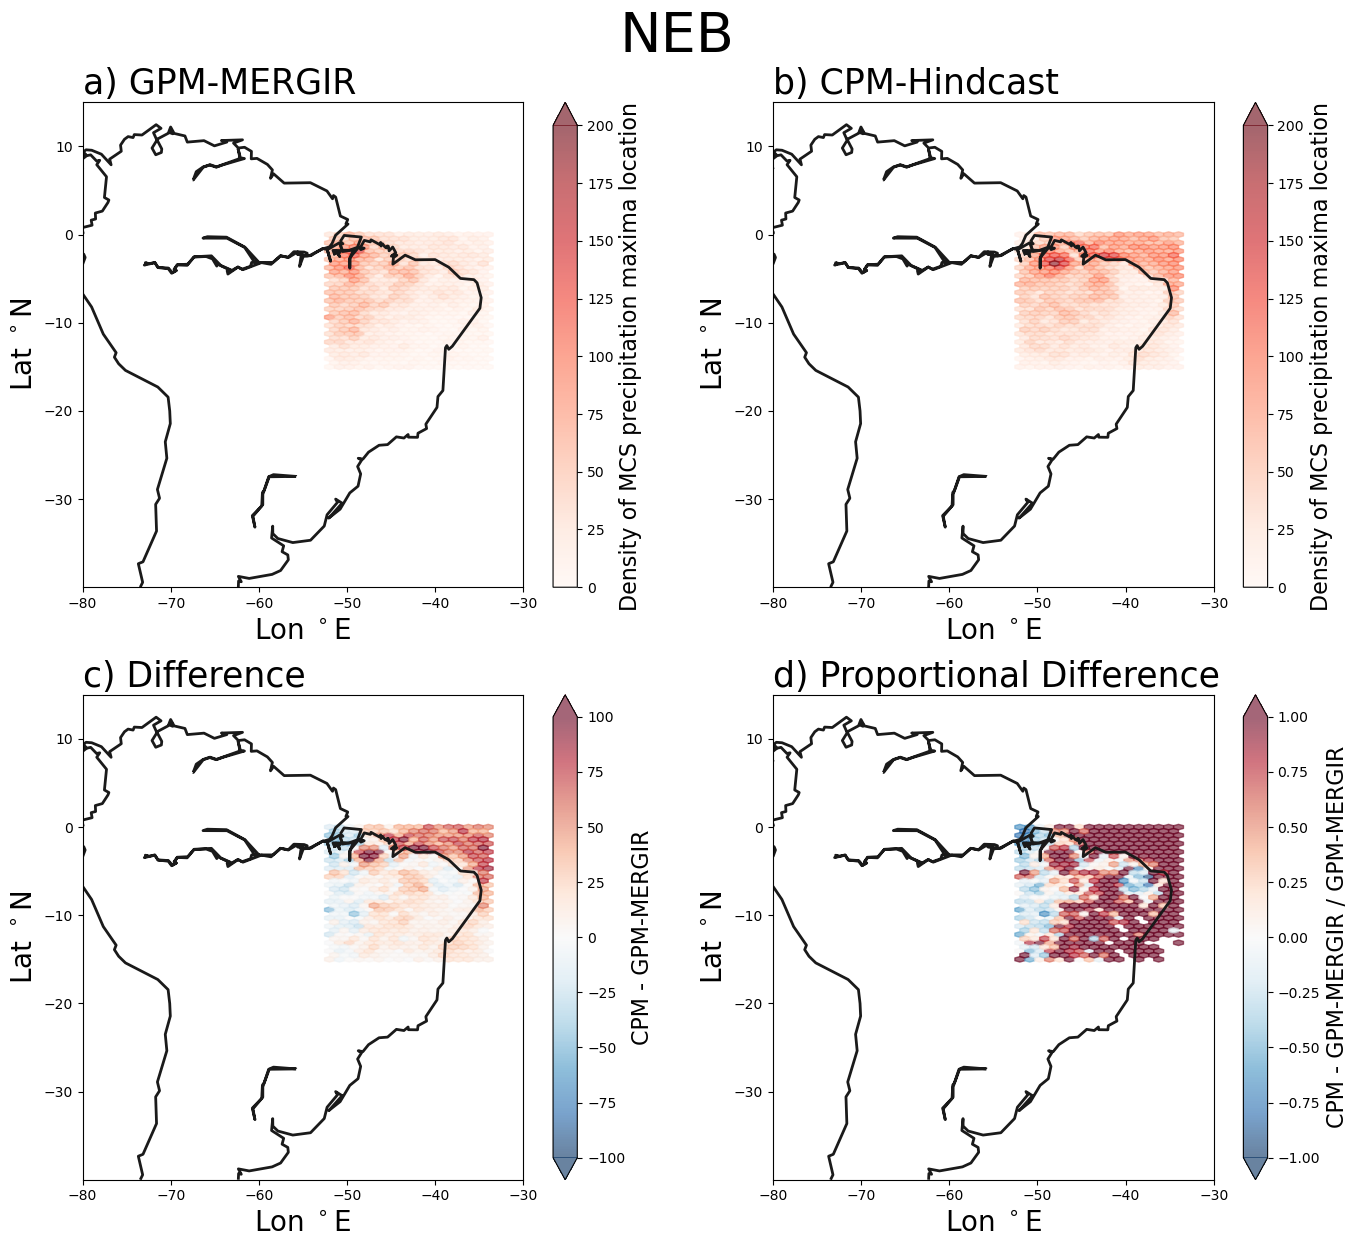

In [286]:
import mpl_toolkits
from mpl_toolkits.basemap import Basemap
import matplotlib.patches as mpatches
from matplotlib.patches import Polygon


x_f = neb_tracks_cpm.max_precip_lon
y_f = neb_tracks_cpm.max_precip_lat

x_o = neb_tracks_obs.max_precip_lon
y_o = neb_tracks_obs.max_precip_lat

### North East Brazil (52-34^W, 15-0^S) ###


fig = plt.figure(figsize=(14,12))

ax1=plt.subplot(2,2,1)
m = Basemap(llcrnrlon=-80, llcrnrlat=-40,urcrnrlon=-30, urcrnrlat=15) # create Basemap object
m.drawcoastlines(linewidth=2) # draw coastlines
#m.drawcountries() # draw political boundaries
#m.shadedrelief()
hx_o = m.hexbin(x_o, y_o, gridsize=(16,16),cmap='Reds',alpha=0.6, vmin=0,vmax=200, extent=(-52, -34, -15, 0))
cbar = plt.colorbar(hx_o, ax=ax1, shrink=1, extend='max')
cbar.set_label(label='Density of MCS precipitation maxima location', fontsize=16)
ax1.set_xlabel('Lon $^\circ$E', fontsize=20)
ax1.set_ylabel('Lat $^\circ$N', fontsize=20)
ax1.set_xticks([-80,-70,-60,-50,-40,-30],fontsize=20)
ax1.set_yticks([-30,-20,-10,0,10],fontsize=20)
ax1.grid(False)
ax1.set_title('a) GPM-MERGIR', loc='left',fontsize=25)


ax2=plt.subplot(2,2,2)
m = Basemap(llcrnrlon=-80, llcrnrlat=-40,urcrnrlon=-30, urcrnrlat=15) # create Basemap object
m.drawcoastlines(linewidth=2) # draw coastlines
#m.drawcountries() # draw political boundaries
#m.shadedrelief()
hx_f = m.hexbin(x_f, y_f, gridsize=(16,16),cmap='Reds',alpha=0.6, vmin=0,vmax=200, extent=(-52, -34, -15, 0))
cbar = plt.colorbar(hx_f, ax=ax2, shrink=1, extend='max')
cbar.set_label(label='Density of MCS precipitation maxima location', fontsize=16)
ax2.set_xlabel('Lon $^\circ$E', fontsize=20)
ax2.set_ylabel('Lat $^\circ$N', fontsize=20)
ax2.set_xticks([-80,-70,-60,-50,-40,-30],fontsize=20)
ax2.set_yticks([-30,-20,-10,0,10],fontsize=20)
ax2.grid(False)
ax2.set_title('b) CPM-Hindcast', loc='left',fontsize=25)


ax3=plt.subplot(2,2,3)
m = Basemap(llcrnrlon=-80, llcrnrlat=-40,urcrnrlon=-30, urcrnrlat=15) # create Basemap object
m.drawcoastlines(linewidth=2) # draw coastlines
#m.drawcountries() # draw political boundaries
#m.shadedrelief()

# Create dummy hexbin using whatever data..:
hx_diff=m.hexbin(x_f, y_f, gridsize=(16,16),cmap='RdBu_r',alpha=0.6, vmin=-100,vmax=100, extent=(-52, -34, -15, 0))
hx_diff.set_array(hx_f.get_array()-hx_o.get_array())
cbar = plt.colorbar(hx_diff, ax=ax3, shrink=1, extend='both')
cbar.set_label(label='CPM - GPM-MERGIR', fontsize=16)
#cbar.ax.tick_params(labelsize=12)
ax3.set_xlabel('Lon $^\circ$E', fontsize=20)
ax3.set_ylabel('Lat $^\circ$N', fontsize=20)
ax3.set_xticks([-80,-70,-60,-50,-40,-30],fontsize=20)
ax3.set_yticks([-30,-20,-10,0,10],fontsize=20)
ax3.grid(False)
ax3.set_title('c) Difference', loc='left',fontsize=25)


ax4=plt.subplot(2,2,4)
m = Basemap(llcrnrlon=-80, llcrnrlat=-40,urcrnrlon=-30, urcrnrlat=15) # create Basemap object
m.drawcoastlines(linewidth=2) # draw coastlines
#m.drawcountries() # draw political boundaries
#m.shadedrelief()

# Create dummy hexbin using whatever data..:
hx_diff=m.hexbin(x_f, y_f, gridsize=(16,16),cmap='RdBu_r',alpha=0.6, vmin=-1,vmax=1, extent=(-52, -34, -15, 0))
hx_diff.set_array((hx_f.get_array()-hx_o.get_array())/hx_o.get_array())
cbar = plt.colorbar(hx_diff, ax=ax4, shrink=1, extend='both')
cbar.set_label(label='CPM - GPM-MERGIR / GPM-MERGIR', fontsize=16)
#cbar.ax.tick_params(labelsize=12)
ax4.set_xlabel('Lon $^\circ$E', fontsize=20)
ax4.set_ylabel('Lat $^\circ$N', fontsize=20)
ax4.set_xticks([-80,-70,-60,-50,-40,-30],fontsize=20)
ax4.set_yticks([-30,-20,-10,0,10],fontsize=20)
ax4.grid(False)
ax4.set_title('d) Proportional Difference', loc='left',fontsize=25)

fig.text(0.46,1,'NEB', fontsize=40)

plt.tight_layout()

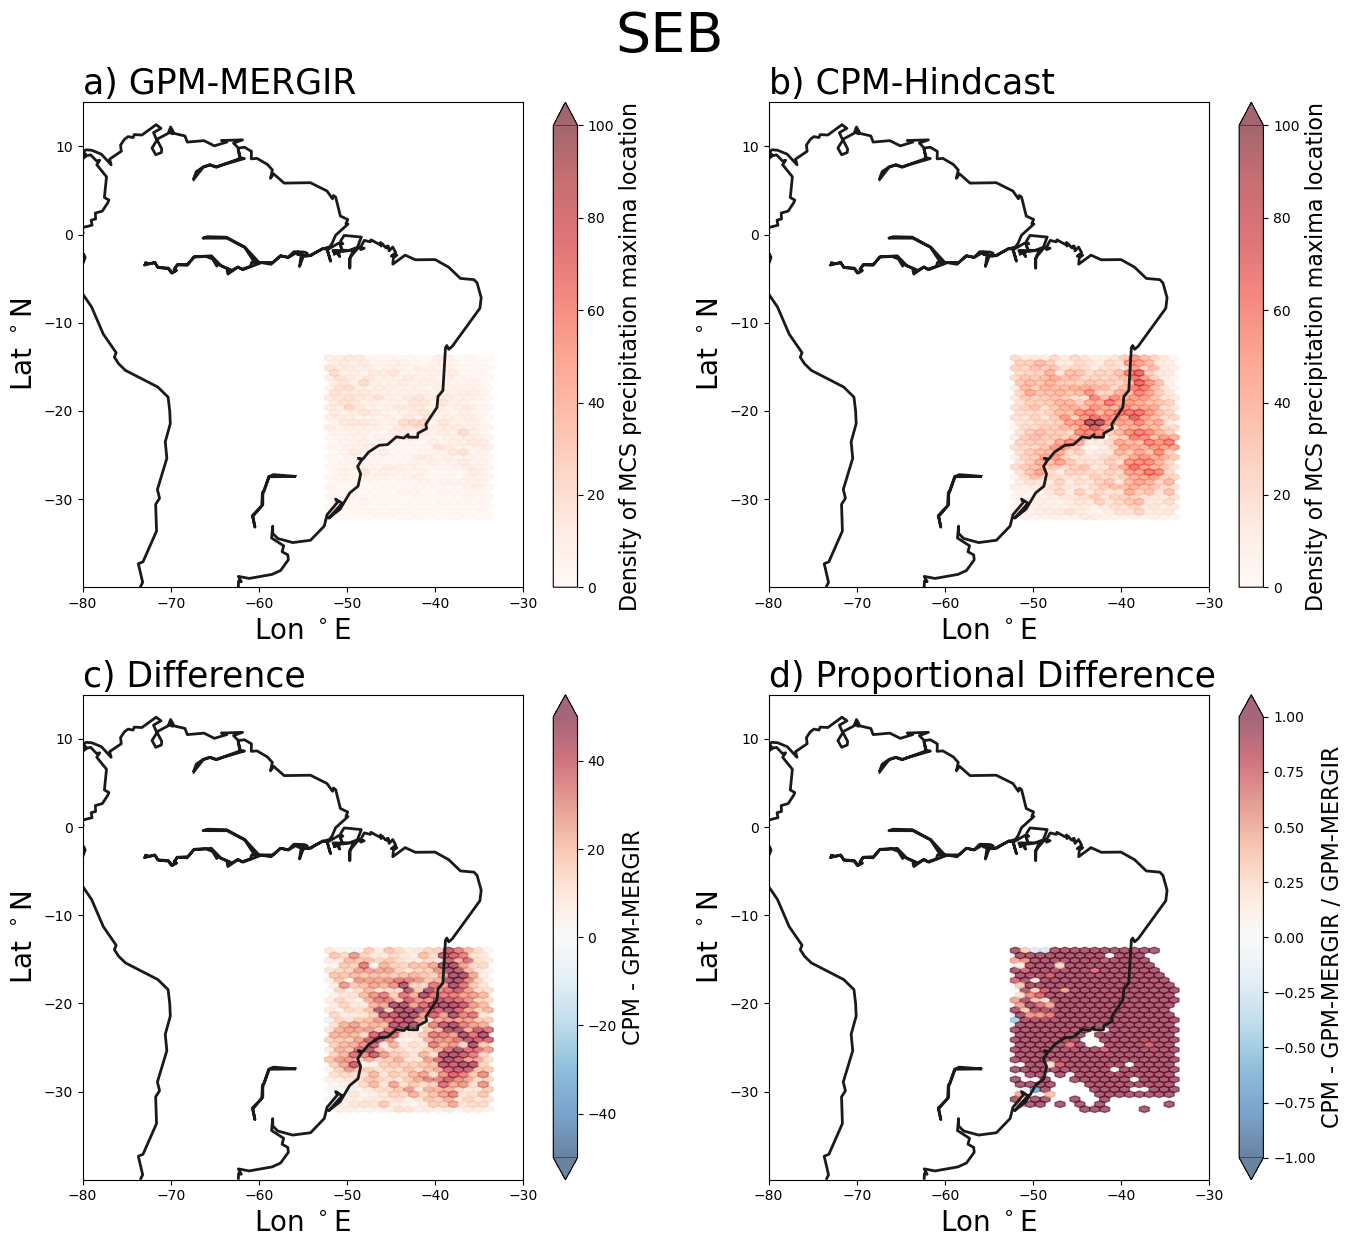

In [288]:
import mpl_toolkits
from mpl_toolkits.basemap import Basemap
import matplotlib.patches as mpatches
from matplotlib.patches import Polygon


x_f = seb_tracks_cpm.max_precip_lon
y_f = seb_tracks_cpm.max_precip_lat

x_o = seb_tracks_obs.max_precip_lon
y_o = seb_tracks_obs.max_precip_lat

### South East Brazil (52-34^w, 32-14^S) ###

fig = plt.figure(figsize=(14,12))

ax1=plt.subplot(2,2,1)
m = Basemap(llcrnrlon=-80, llcrnrlat=-40,urcrnrlon=-30, urcrnrlat=15) # create Basemap object
m.drawcoastlines(linewidth=2) # draw coastlines
#m.drawcountries() # draw political boundaries
#m.shadedrelief()
hx_o = m.hexbin(x_o, y_o, gridsize=(16,16),cmap='Reds',alpha=0.6, vmin=0,vmax=100, extent=(-52, -34, -32, -14))
cbar = plt.colorbar(hx_o, ax=ax1, shrink=1, extend='max')
cbar.set_label(label='Density of MCS precipitation maxima location', fontsize=16)
ax1.set_xlabel('Lon $^\circ$E', fontsize=20)
ax1.set_ylabel('Lat $^\circ$N', fontsize=20)
ax1.set_xticks([-80,-70,-60,-50,-40,-30],fontsize=20)
ax1.set_yticks([-30,-20,-10,0,10],fontsize=20)
ax1.grid(False)
ax1.set_title('a) GPM-MERGIR', loc='left',fontsize=25)


ax2=plt.subplot(2,2,2)
m = Basemap(llcrnrlon=-80, llcrnrlat=-40,urcrnrlon=-30, urcrnrlat=15) # create Basemap object
m.drawcoastlines(linewidth=2) # draw coastlines
#m.drawcountries() # draw political boundaries
#m.shadedrelief()
hx_f = m.hexbin(x_f, y_f, gridsize=(16,16),cmap='Reds',alpha=0.6, vmin=0,vmax=100, extent=(-52, -34, -32, -14))
cbar = plt.colorbar(hx_f, ax=ax2, shrink=1, extend='max')
cbar.set_label(label='Density of MCS precipitation maxima location', fontsize=16)
ax2.set_xlabel('Lon $^\circ$E', fontsize=20)
ax2.set_ylabel('Lat $^\circ$N', fontsize=20)
ax2.set_xticks([-80,-70,-60,-50,-40,-30],fontsize=20)
ax2.set_yticks([-30,-20,-10,0,10],fontsize=20)
ax2.grid(False)
ax2.set_title('b) CPM-Hindcast', loc='left',fontsize=25)


ax3=plt.subplot(2,2,3)
m = Basemap(llcrnrlon=-80, llcrnrlat=-40,urcrnrlon=-30, urcrnrlat=15) # create Basemap object
m.drawcoastlines(linewidth=2) # draw coastlines
#m.drawcountries() # draw political boundaries
#m.shadedrelief()

# Create dummy hexbin using whatever data..:
hx_diff=m.hexbin(x_f, y_f, gridsize=(16,16),cmap='RdBu_r',alpha=0.6, vmin=-50,vmax=50, extent=(-52, -34, -32, -14))
hx_diff.set_array(hx_f.get_array()-hx_o.get_array())
cbar = plt.colorbar(hx_diff, ax=ax3, shrink=1, extend='both')
cbar.set_label(label='CPM - GPM-MERGIR', fontsize=16)
#cbar.ax.tick_params(labelsize=12)
ax3.set_xlabel('Lon $^\circ$E', fontsize=20)
ax3.set_ylabel('Lat $^\circ$N', fontsize=20)
ax3.set_xticks([-80,-70,-60,-50,-40,-30],fontsize=20)
ax3.set_yticks([-30,-20,-10,0,10],fontsize=20)
ax3.grid(False)
ax3.set_title('c) Difference', loc='left',fontsize=25)


ax4=plt.subplot(2,2,4)
m = Basemap(llcrnrlon=-80, llcrnrlat=-40,urcrnrlon=-30, urcrnrlat=15) # create Basemap object
m.drawcoastlines(linewidth=2) # draw coastlines
#m.drawcountries() # draw political boundaries
#m.shadedrelief()

# Create dummy hexbin using whatever data..:
hx_diff=m.hexbin(x_f, y_f, gridsize=(16,16),cmap='RdBu_r',alpha=0.6, vmin=-1,vmax=1, extent=(-52, -34, -32, -14))
hx_diff.set_array((hx_f.get_array()-hx_o.get_array())/hx_o.get_array())
cbar = plt.colorbar(hx_diff, ax=ax4, shrink=1, extend='both')
cbar.set_label(label='CPM - GPM-MERGIR / GPM-MERGIR', fontsize=16)
#cbar.ax.tick_params(labelsize=12)
ax4.set_xlabel('Lon $^\circ$E', fontsize=20)
ax4.set_ylabel('Lat $^\circ$N', fontsize=20)
ax4.set_xticks([-80,-70,-60,-50,-40,-30],fontsize=20)
ax4.set_yticks([-30,-20,-10,0,10],fontsize=20)
ax4.grid(False)
ax4.set_title('d) Proportional Difference', loc='left',fontsize=25)

fig.text(0.46,1,'SEB', fontsize=40)

plt.tight_layout()

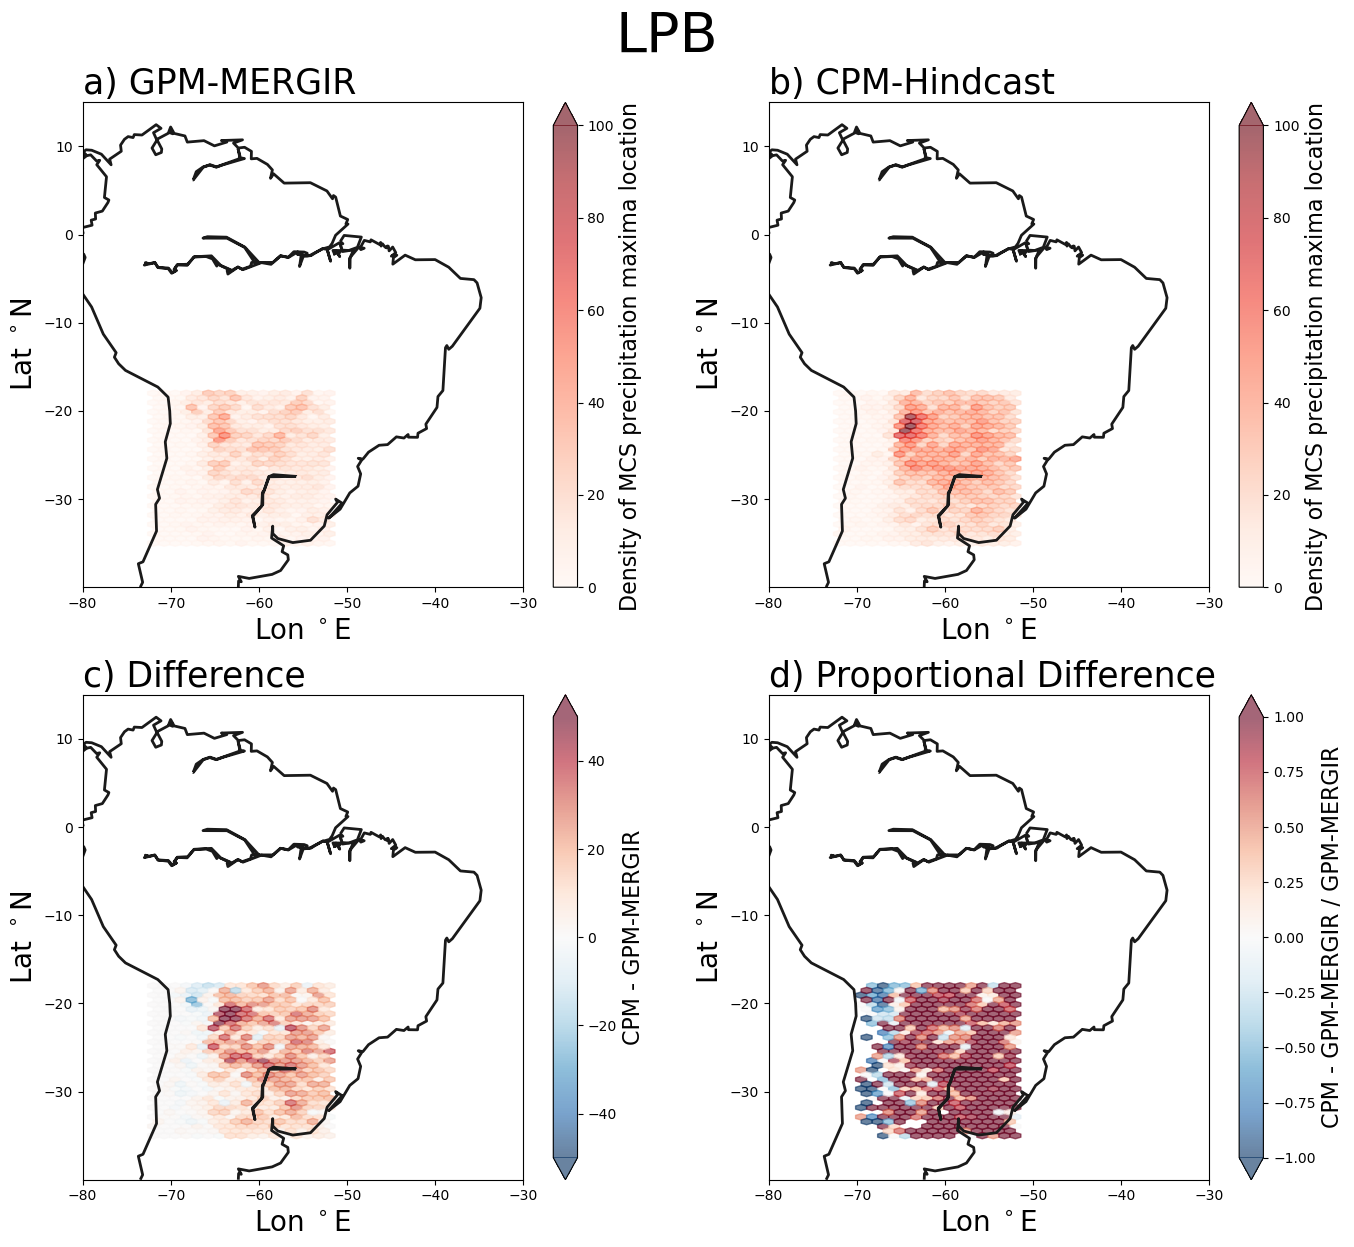

In [290]:
import mpl_toolkits
from mpl_toolkits.basemap import Basemap
import matplotlib.patches as mpatches
from matplotlib.patches import Polygon


x_f = lpb_tracks_cpm.max_precip_lon
y_f = lpb_tracks_cpm.max_precip_lat

x_o = lpb_tracks_obs.max_precip_lon
y_o = lpb_tracks_obs.max_precip_lat

### La Plata Basin (72-52^W, 35-18^S) ###

fig = plt.figure(figsize=(14,12))

ax1=plt.subplot(2,2,1)
m = Basemap(llcrnrlon=-80, llcrnrlat=-40,urcrnrlon=-30, urcrnrlat=15) # create Basemap object
m.drawcoastlines(linewidth=2) # draw coastlines
#m.drawcountries() # draw political boundaries
#m.shadedrelief()
hx_o = m.hexbin(x_o, y_o, gridsize=(16,16),cmap='Reds',alpha=0.6, vmin=0,vmax=100, extent=(-72, -52, -35, -18))
cbar = plt.colorbar(hx_o, ax=ax1, shrink=1, extend='max')
cbar.set_label(label='Density of MCS precipitation maxima location', fontsize=16)
ax1.set_xlabel('Lon $^\circ$E', fontsize=20)
ax1.set_ylabel('Lat $^\circ$N', fontsize=20)
ax1.set_xticks([-80,-70,-60,-50,-40,-30],fontsize=20)
ax1.set_yticks([-30,-20,-10,0,10],fontsize=20)
ax1.grid(False)
ax1.set_title('a) GPM-MERGIR', loc='left',fontsize=25)


ax2=plt.subplot(2,2,2)
m = Basemap(llcrnrlon=-80, llcrnrlat=-40,urcrnrlon=-30, urcrnrlat=15) # create Basemap object
m.drawcoastlines(linewidth=2) # draw coastlines
#m.drawcountries() # draw political boundaries
#m.shadedrelief()
hx_f = m.hexbin(x_f, y_f, gridsize=(16,16),cmap='Reds',alpha=0.6, vmin=0,vmax=100, extent=(-72, -52, -35, -18))
cbar = plt.colorbar(hx_f, ax=ax2, shrink=1, extend='max')
cbar.set_label(label='Density of MCS precipitation maxima location', fontsize=16)
ax2.set_xlabel('Lon $^\circ$E', fontsize=20)
ax2.set_ylabel('Lat $^\circ$N', fontsize=20)
ax2.set_xticks([-80,-70,-60,-50,-40,-30],fontsize=20)
ax2.set_yticks([-30,-20,-10,0,10],fontsize=20)
ax2.grid(False)
ax2.set_title('b) CPM-Hindcast', loc='left',fontsize=25)


ax3=plt.subplot(2,2,3)
m = Basemap(llcrnrlon=-80, llcrnrlat=-40,urcrnrlon=-30, urcrnrlat=15) # create Basemap object
m.drawcoastlines(linewidth=2) # draw coastlines
#m.drawcountries() # draw political boundaries
#m.shadedrelief()

# Create dummy hexbin using whatever data..:
hx_diff=m.hexbin(x_f, y_f, gridsize=(16,16),cmap='RdBu_r',alpha=0.6, vmin=-50,vmax=50, extent=(-72, -52, -35, -18))
hx_diff.set_array(hx_f.get_array()-hx_o.get_array())
cbar = plt.colorbar(hx_diff, ax=ax3, shrink=1, extend='both')
cbar.set_label(label='CPM - GPM-MERGIR', fontsize=16)
#cbar.ax.tick_params(labelsize=12)
ax3.set_xlabel('Lon $^\circ$E', fontsize=20)
ax3.set_ylabel('Lat $^\circ$N', fontsize=20)
ax3.set_xticks([-80,-70,-60,-50,-40,-30],fontsize=20)
ax3.set_yticks([-30,-20,-10,0,10],fontsize=20)
ax3.grid(False)
ax3.set_title('c) Difference', loc='left',fontsize=25)


ax4=plt.subplot(2,2,4)
m = Basemap(llcrnrlon=-80, llcrnrlat=-40,urcrnrlon=-30, urcrnrlat=15) # create Basemap object
m.drawcoastlines(linewidth=2) # draw coastlines
#m.drawcountries() # draw political boundaries
#m.shadedrelief()

# Create dummy hexbin using whatever data..:
hx_diff=m.hexbin(x_f, y_f, gridsize=(16,16),cmap='RdBu_r',alpha=0.6, vmin=-1,vmax=1, extent=(-72, -52, -35, -18))
hx_diff.set_array((hx_f.get_array()-hx_o.get_array())/hx_o.get_array())
cbar = plt.colorbar(hx_diff, ax=ax4, shrink=1, extend='both')
cbar.set_label(label='CPM - GPM-MERGIR / GPM-MERGIR', fontsize=16)
#cbar.ax.tick_params(labelsize=12)
ax4.set_xlabel('Lon $^\circ$E', fontsize=20)
ax4.set_ylabel('Lat $^\circ$N', fontsize=20)
ax4.set_xticks([-80,-70,-60,-50,-40,-30],fontsize=20)
ax4.set_yticks([-30,-20,-10,0,10],fontsize=20)
ax4.grid(False)
ax4.set_title('d) Proportional Difference', loc='left',fontsize=25)

fig.text(0.46,1,'LPB', fontsize=40)

plt.tight_layout()

In [155]:
pd.set_option("display.max_columns", 50)
eamz_tracks_cpm.head()

frame  idx      hdim_1      hdim_2    num  threshold_value  feature  \
31      2  124  717.927725  695.554445  21717              240       32   
43      3   83  707.899711  676.785055  27282              240       44   
55      4   92  729.683324  682.654579  21082              240       56   
69      5   78  734.215714  681.560944  20502              240       70   
80      6   86  739.736455  681.749094  20604              240       81   

                   time              timestr   latitude  longitude    cell  \
31  2001-01-01 02:30:00  2001-01-01 02:30:00 -10.963977 -56.870003  200116   
43  2001-01-01 03:30:00  2001-01-01 03:30:00 -11.370112 -57.630165  200116   
55  2001-01-01 04:30:00  2001-01-01 04:30:00 -10.487876 -57.392437  200116   
69  2001-01-01 05:30:00  2001-01-01 05:30:00 -10.304315 -57.436726  200116   
80  2001-01-01 06:30:00  2001-01-01 06:30:00 -10.080724 -57.429106  200116   

         time_cell  total_precip  rain_flag  convective_precip  heavy_precip  \
31 0 days 00:00:00  7.866571e+03        821        7656.430664   5136.735840   
43 0 days 01:00:00  8.874375e-08          0           0.000000      0.000000   
55 0 days 02:00:00  6.878510e+03        921        6687.748047   3720.273438   
69 0 days 03:00:00  6.236374e+03        789        6012.055664   3576.546631   
80 0 days 04:00:00  5.648553e+03        697        5469.906250   3380.437500   

    extreme_precip  heavy_rain_flag  extreme_rain_flag    max_precip  \
31     1232.795898              206                 19  8.960225e+01   
43        0.000000                0                  0  8.874375e-08   
55      467.787231              173                  8  7.838945e+01   
69      333.780731              165                  5  8.187802e+01   
80      250.644409              166                  4  8.052079e+01   

    mean_precip_total  mean_precip      tb_min     tb_mean  ...  tb_190  \
31       2.204756e+00     9.325738  188.930908  215.122589  ...      60   
43       8.874375e-08          NaN  240.394089  240.394089  ...       0   
55       2.005396e+00     7.261398  191.071259  216.444168  ...       0   
69       1.861048e+00     7.619843  193.707565  217.871124  ...       0   
80       1.673150e+00     7.847785  195.670898  220.611862  ...       0   

    tb_180     w_max     w_min    w_mean  w_mean_up  w_mean_down  w_up_area  \
31       0       NaN       NaN       NaN        NaN          NaN        NaN   
43       0 -0.037954 -0.037954 -0.037954        NaN    -0.037954        0.0   
55       0       NaN       NaN       NaN        NaN          NaN        NaN   
69       0       NaN       NaN       NaN        NaN          NaN        NaN   
80       0  4.685681 -0.439730  0.069701   0.164832    -0.053053     1902.0   

    w_down_area  w_0.1_up  w_1_up  w_5_up  w_0.1_down  w_1_down  w_5_down  \
31          NaN       NaN     NaN     NaN         NaN       NaN       NaN   
43          1.0       0.0     0.0     0.0         0.0       0.0       0.0   
55          NaN       NaN     NaN     NaN         NaN       NaN       NaN   
69          NaN       NaN     NaN     NaN         NaN       NaN       NaN   
80       1474.0     478.0    79.0     0.0       228.0       0.0       0.0   

              datetime  max_precip_lat max_precip_lon min_tb_lat min_tb_lon  \
31 2001-01-01 02:30:00           -9.15     -56.450001      -9.55 -56.349998   
43 2001-01-01 03:30:00          -17.25     -61.049999     -17.25 -61.049999   
55 2001-01-01 04:30:00           -8.85     -56.150002     -10.55     -57.25   
69 2001-01-01 05:30:00           -8.95     -56.150002      -9.95 -55.450001   
80 2001-01-01 06:30:00          -10.35     -55.450001     -10.35 -55.549999   

   max_w_up_lat max_w_up_lon max_w_down_lat max_w_down_lon colocated_pixels  
31            0            0              0              0              617  
43       -17.25   -61.049999         -17.25     -61.049999                0  
55            0            0              0              0              